# Assignment

## Problem description

You have already performed an exploratory data analysis to get to know your training data. The real estate company is interested in predicting the prices of houses with three bedrooms for each month from January 2020 until July 2022. You decide to model the problem with two different approaches:

* **First approach (model A).** As a supervised regression task. You will use a regression technique for predicting the prices of houses with three bedrooms based on response features that you create from the available data. The resulting dataset should not be time-dependent.

  Helpful modules: Topics of Lectures 1 to 4. Specially Lecture 4 for creating features based on temporal data.

* **Second approach (model B).** As a time series forecasting task. You will use a recurrent neural network architecture (e.g., LSTM) to predict the prices of houses with three bedrooms based on the previous prices of all properties. Your data will be in the form of time-dependent sequences.

  Helpful modules: Topics of Lectures 1 to 6. Specially Lectures 5 and 6 for the content related to neural networks.

Similarly to the first part of the assignment, you have access to data on property sales from the last decade, starting in 2010. The property prices are measured on the day of the sale. The sales data also include characteristics such as the number of bedrooms and whether the property is a house or an apartment (unit). Notice that there could be more than one sale in a month; similarly, there could be months without sales for a particular type and size of the property.

The data available for model training and selection is in the file `realestate_train.csv`. This dataset contains the sales from 2010 until 2019. A separate dataset for testing is available in the file `realestate_test.csv`. This dataset contains the sales from January 2020 until July 2022 that should be predicted.

## Questions

### Model A

* **A1.** Perform all data pre-processing steps needed for model A (i.e., integration, cleaning, reduction, and transformation). For each pre-processing step that you apply, dedicate at least one markdown cell next to the code to explain:

  * the step you are applying
  * why you need to do it
  * what is the result

  Note: In some scenarios, it is acceptable to repeat steps; however, make sure your code is logical and efficient.

* **A2.** In a separate markdown cell, summarize which features you create and their meaning. Motivate your strategy for creating these features.

* **A3.** Prepare your data for model selection and evaluation. What is the experimental setup that you use to build Model A? Please provide a figure that summarizes your setup where you clearly mark:

  * how do you split the available data for training, validation, or testing
  * what type of validation strategy do you use (e.g., hold out, cross-validation)

  Hint: you can include a figure in markdown syntax as follows:

  ```markdown
  ![Example Image](/images/example.jpg)
  ```

* **A4.** Choose a machine learning algorithm to build model A (e.g., regression, decision tree, neural network, etc.) and implement your solution. Motivate which hyperparameters you select or optimize.

* **A5.** Evaluate the performance of model A. Describe which measures you use and discuss the results of the evaluation

### Model B

* **B1.** Perform all data pre-processing steps needed for model B (i.e., integration, cleaning, reduction, and transformation). For each pre-processing step that you apply, dedicate at least one markdown cell next to the code to explain:

  * the step you are applying
  * why you need to do it
  * what is the result

  Note: In some scenarios, it is acceptable to repeat steps; however, make sure your code is logical and efficient.

* **B2.** In a separate markdown cell, summarize how you organize your time-dependent data. Motivate your strategy. You can include a figure if needed.

* **B3.** Prepare your data for model selection and evaluation. What is the experimental setup that you use to build Model B? Please provide a figure that summarizes your setup where you clearly mark:

  * how do you split the available data for training, validation, or testing
  * what type of validation strategy do you use (e.g., hold out, cross-validation)

  Hint: you can include a figure in markdown syntax as follows:

  ```markdown
  ![Example Image](/images/example.jpg)
  ```

* **B4.** Choose a recurrent neural network architecture to build model B (e.g., LSTM, GRU, etc.) and implement your solution. Motivate which hyperparameters you select or optimize.

* **B5.** Evaluate the performance of model B. Describe which measures you use and discuss the results of the evaluation.

### Model Comparison

* **C1.** Create a plot contrasting the predictions of model A, model B, and the ground truth values from the test set.

* **C2.** Based on the results, which model would you recommend to the real estate company? Motivate your answer.

## Instructions

* Assignments are to be done in groups. Sharing of ideas is encouraged. Plagiarism will be strictly penalized.
* The report will be written within the jupyter notebook code. Mark the notebook cells as type ‘markdown’ to write formatted text when answering the questions. Use headings and subheadings to organize your answers. Do not use python comments to answer the questions. Do not submit a separate PDF report. All analyses should be logically structured and contained in the notebook.
* Motivate your answers with sufficient discussion but avoid redundancy. Be concise and to the point.
* Use terminology and academic language correctly.
* Retake is not possible.
* Assignments are only valid for the current academic year.

### Deliverables

A zip file containing

* A jupyter notebook report with your code and answers to the questions.
* Any image files that you inserted in your notebook report.
* A copy of the jupyter notebook saved as an HTML file.

### Deadline

4th April 2023, 20:00. Late submissions will be penalized.

# Full implementation

## Setup

### Imports

The following code shell shows the imports of the libraries we have used for model A. These imports are used to bring in external libraries or modules that provide additional functionality to the program. These libraries can be used to perform specific tasks, such as data manipulation, visualization, or machine learning. The import statement is used to load the library or module into the current program, making its functions and classes available for use. In some cases, specific functions or classes can be imported from a library to reduce memory usage and improve program performance.


In [223]:
from math import sqrt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from dataclasses import dataclass, asdict

from typing import Tuple

import sklearn
import sklearn.metrics as metrics
from sklearn import decomposition, tree
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import cross_val_predict, train_test_split, GridSearchCV, RepeatedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import loguniform

from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Bidirectional


### Configuration

In [202]:
DS_PATH_TRAIN = "realestate_train.csv"
DS_PATH_TEST = "realestate_test.csv"

color_palette = lambda vals: sns.color_palette("coolwarm", vals)

## Data loading

Loading data from CSV (Comma Separated Values) files is a common task in data analysis and machine learning. CSV files are a simple way to store data in a tabular format, where each row represents an observation and each column represents a variable. Pandas library allow us to read CSV files and convert them into data frames. We load the training and test data from the CSV files and build a dataframe with the corresponding datatypes of the columns. 


In [203]:
def load_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
    types = {
        "price": np.uint32,
        "type": str,
        "bedrooms": np.uint8
    }

    df = pd.read_csv(DS_PATH_TRAIN, dtype=types, parse_dates=["date"])
    df_test = pd.read_csv(DS_PATH_TEST, dtype=types, parse_dates=["date"])
    return df, df_test

## Model A

In [204]:
df, df_test = load_data()

### Data preparation

Data preparation is a crucial step in the machine learning process that involves cleaning, transforming, and pre-processing raw data to make it suitable for use in a machine learning model. The main goal of data preparation is to ensure that the data is accurate, complete, and relevant to the problem at hand. This involves removing any missing or duplicate values, dealing with outliers, scaling and normalizing the data, and encoding categorical variables.

Additionally, we add three new columns (year, month, day) that we will use further on.

In [205]:
df_test["year"] = df_test["date"].dt.year
df_test["month"] = df_test["date"].dt.month
df_test["day"] = df_test["date"].dt.day

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

We also define this dictionary to get access to the hyperparametrs.

In [206]:
hyperParams = {}

#### Data analysis

After loading the proper data, we are ready to visualize the distribution of the price for both datasets to determine outliers. A plot of the number of properties according to prices is a common visualization used in the real estate industry to understand the distribution of property prices in a given area. This type of plot shows the number of properties on the y-axis and the price range on the x-axis. 
We will make use of the seaborn library in order to generate this kind of graph with the test data according to price.

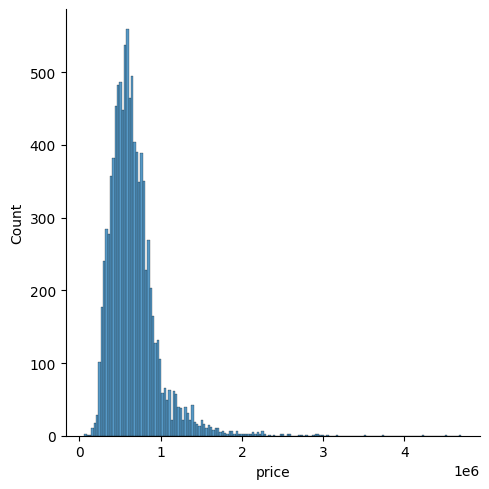

In [207]:
sns.displot(df_test, x="price")

Now, we will use the seaborn library again to visualize the training data. The resulting graph reveals important insights into the local real estate market. It is reasonable to assume that the properties with a price higher than 1 million are not a representative part from the data. Therefore, we can define them as outliers and get rid of them at the data preparation. 


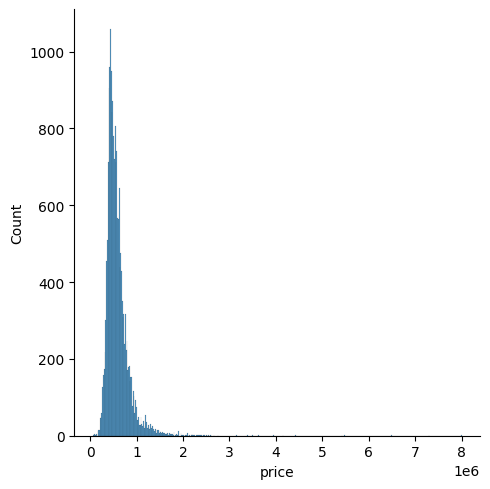

In [208]:
sns.displot(df, x="price")

Finally, we make use of a correlation heatmap which is a useful tool for identifying pattern and relationships between variables in a dataset. In the case of a dataset that includes both housing prices and the number of bedrooms in each home, a correlation heatmap can be used to determine if there is a relationship between these two variables. The heatmap shows a strong positive correlation between price and bedrooms, this indicates that homes with more bedrooms tend to have higher prices.  

/var/folders/59/rtx0j4495cjgfgh5kz_8w6kc0000gn/T/ipykernel_1677/3453718612.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df.corr())


Text(0.5, 1.0, 'Correlation Heatmap for the Training set')

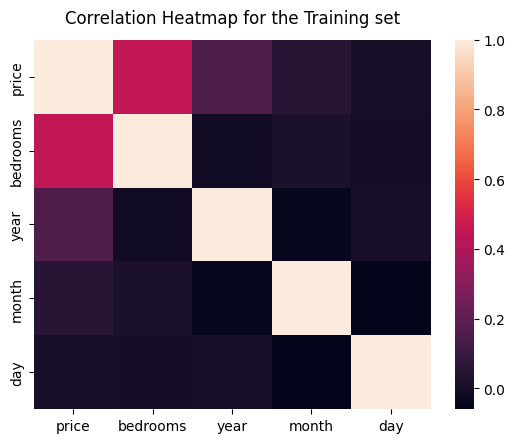

In [209]:
heatmap = sns.heatmap(df.corr())
heatmap.set_title('Correlation Heatmap for the Training set', fontdict={'fontsize':12}, pad=12)

#### Data cleaning

Data cleaning is an important step in the machine learning process as the quality of the data determines the accuracy and effectiveness of the model. It involves identifying and correcting inaccuracies, inconsistencies, and missing information in the dataset. The process involves various techniques including removing or imputing missing data, identifying and eliminating duplicate entries, correcting errors, handling outliers and transforming data into a usable format for analysis. Data cleaning helps to remove biases, ensure data integrity and improve the quality of the dataset. It is a time-consuming process but necessary for building robust and accurate machine learning models.

Therefore, after the data anylysis been made, we get rid of the outliers by removing the properties with no berooms and a price higher than 1 million. 

In [210]:
def data_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df['bedrooms'] >= 1) & (df['price'] <= 1000000)].copy()

#### Feature Engineering

Feature engineering is a process of preparing variables or features that are used as input in machine learning models. This process involves selecting, creating, and transforming variables to achieve optimal model performance. Feature engineering requires a deep understanding of the problem domain, machine learning algorithms, and data. It involves techniques such as scaling, normalization, and one-hot encoding, as well as the creation of new variables derived from existing ones through mathematical operations or other data processing techniques. Feature engineering plays a critical role in the success of predictive modeling by improving model accuracy, reducing overfitting, and increasing interpretability. 

It requires a combination of knowledge, creativity, and resourcefulness to extract useful insights from data that are relevant to the problem at hand. Moreover, we start the feature engineering by implementing the scaler and creating new different features based on the ones given in the file:

1. The mean price per bedroom
2. The price scaled
3. The mean price per bedroom of the previous entry
4. The mean price per bedroom shifted by 2
5. The mean price per bedroom shifted by 3
6. The delta between the relevant mean bedroom price and the mean bedroom price of the previous entry
7. The bedrooms scaled
8. The mean price per bedroom scaled
9. The mean price per bedroom of the previous entry scaled
10. The delta between the relevant mean bedroom price and the mean bedroom price of the previous entry scaled
11. The mean price per month

While the the feature engineering process is essential to this task, we are aware that most of our engineered features find little to no use in the prediction, as they inherit information about the target, thus making it obsolete to use them in the regression tasks.

In [211]:
scaler = RobustScaler()
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    # df['meanPricePB'] = df['price'] / df['bedrooms']
    # df['price_scaled'] = scaler.fit_transform(df[['price']])
    # df['prevMeanPricePB'] = df['meanPricePB'].shift(1)
    # df['meanPricePB_shift2'] = df['meanPricePB'].shift(2)
    # df['meanPricePB_shift3'] = df['meanPricePB'].shift(3)
    # df['meanPriceDeltaToYesterday'] = df['meanPricePB'] - df['prevMeanPricePB']
    # df['bedrooms_scaled'] = scaler.fit_transform(df[['bedrooms']])
    # df['meanPricePB_scaled'] = scaler.fit_transform(df[['meanPricePB']])
    # df['prevMeanPricePB_scaled'] = scaler.fit_transform(df[['prevMeanPricePB']])
    # # df['meanPricePB_shift2_scaled'] = scaler.fit_transform(df['meanPricePB_shift2'])
    # # df['meanPricePB_shift3_scaled'] = scaler.fit_transform(df['meanPricePB_shift3'])
    # df['meanPriceDeltaToYesterday_scaled'] = scaler.fit_transform(df[['meanPriceDeltaToYesterday']])
    df = pd.concat([df, pd.get_dummies(df['type'], drop_first=True)], axis = 1)
    # df['date_month'] = df['date'].values.astype('datetime64[M]')
    # df['monthlyMeanPrice'] = df['price']
    # sales_month = df.groupby(['date_month'])[['monthlyMeanPrice']].agg('mean').reset_index()
    # df = df.merge(sales_month, how='left', on=['date_month'])
    # df = df.drop(columns=['monthlyMeanPrice_x'])
    # df = df.rename(columns={"monthlyMeanPrice_y": "monthlyMeanPrice"})
    # df['monthlyMeanPrice_scaled'] = scaler.fit_transform(df[['monthlyMeanPrice']])
    df_agg = df.groupby(['date'])[['price']].agg('mean').reset_index()
    df_agg = df_agg.merge(df,how='left' , on=['date'])
    df_agg = df_agg.drop_duplicates(subset=['date'])
    df_agg = df_agg.drop(columns=['price_x'])
    df_agg = df_agg.rename(columns={"price_y": "price"})
    return df_agg[~df_agg.isnull().any(axis=1)]

#### Data evaluation

We are going to apply the data preparation and the feature engineering to both datasets, training and test datasets, and take a deeper look into the price per bedrooms.

<Axes: xlabel='bedrooms', ylabel='price'>

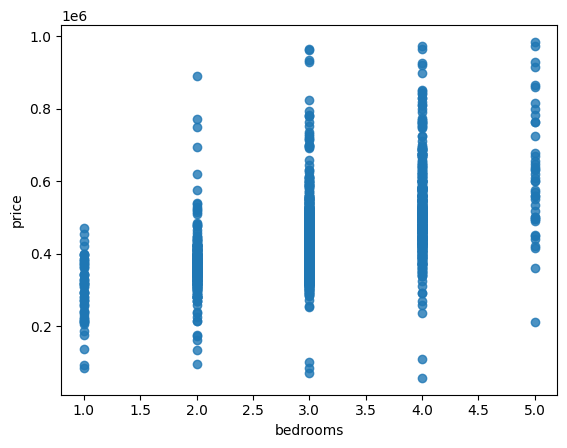

In [212]:
df_train = data_cleaning(df)
df_train = feature_engineering(df_train)

df_train.head()

df_test = data_cleaning(df_test)
df_test = feature_engineering(df_test)

df_viz = df_train.loc[:, ['bedrooms', 'price']]
sns.regplot(x="bedrooms", y="price", data=df_viz, fit_reg=False)

Additionally, we will make use of a correlation heatmap for the training dataset after the feature engineering to determine if there is a relationship between two variables in the dataset. 

/var/folders/59/rtx0j4495cjgfgh5kz_8w6kc0000gn/T/ipykernel_1677/3133570763.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)


Text(0.5, 1.0, 'Correlation Heatmap for the Training set after Feature Engineering')

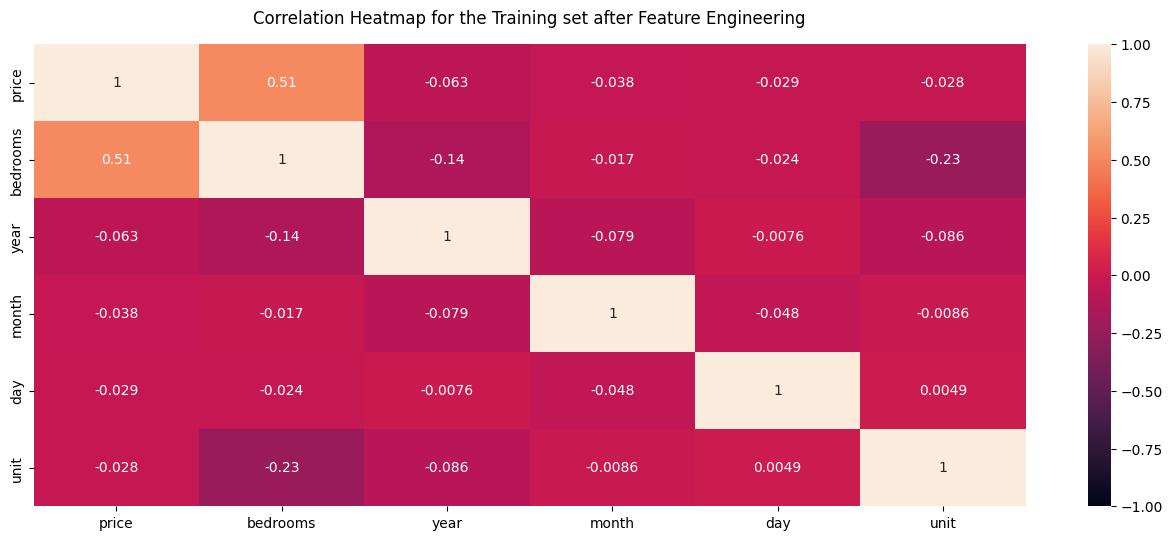

In [213]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap for the Training set after Feature Engineering', fontdict={'fontsize':12}, pad=15)

### Model

Modelling in machine learning involves creating a mathematical and computational representation of a real-world problem to predict outcomes and gain insights. This process starts with selecting an appropriate algorithm that best suits the problem at hand, which then trains on a set of known data to learn patterns and relationships between variables. The trained model is then evaluated on a separate set of data to measure its accuracy and identify any discrepancies. The model is then updated and refined to improve its performance until it reaches the desired level of accuracy. This iterative process of modelling enables machines to make accurate predictions, uncover hidden insights, and automate decision-making in various industries. Furthermore, modelling allows machine learning algorithms to adapt and learn from new data, improving their efficacy over time. In our case, we are predicting the prices of houses with three bedrooms for each month from January 2020 until July 2022.

#### Experiments

Firstly, we need to split the training data set. This is so that the different models do not get insight into the target/test data.

In [214]:
X = df_train[['bedrooms','unit','year','month']]
X = np.array(X)
Y=df_train['price']
Y = np.array(Y)

Y=Y.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

#### Model Selection & Hyperparameter tuning

As previously stated, the given data and the inherited features are sparse. This left us with the wish to try different regression models and approaches to ensure that the resulting predictions and performances can be compared and a reliable conclusion can be formulated. 
The selected regression models for this task are:
1. Ridge Regression
2. Linear Regression
3. Support Vector Regression
4. Decision Tree Classification
5. Random Forest Regression

In order to guarantee that all of the models are applied correctly, a hyperparameter tuning process was implemented for each model. While the Ridge and the Random Forest model both use RandomSearch to determine the best hyperparameters, the other regression models and the decision tree classification make use of girdSearch. All of the tuning processes make use of crossvalidation, to ensure reliable results. 
As a performance score the R2 score is chosen, as it depicts the similarity of predictions to the actual values and can be applied to both search models.

After the hyperparameter tuning is done, the best estimators and relative parameters for each model will be used for the final models and the prediction task.

#### Hyperparameter Dictionary

To get access to the hyperparameters later on for the comparison this function is defined.

In [215]:
def hyperparam_tolist(params, name):
    hyperParams[name] = params

#### Ridge Regression

While the previous correlation matrix indicates that the given features mostly do not have high correlations between each other, a ridge regression is installed to guarantee that the multicollinearity problem is mitigated, before implementing a linear regression model. However the probability for this problem to arise should be relatively low, since the provided data has few features.

The used solvers were chosen to cover a large variety of different approaches, including the 'auto' option, which automatically decides for a fitting solver based on the given data. We assign a random generated searchspace to alpha and define the y-axis intercept parameter.

Furthermore we define a k-fold cross-validation with 10 splits for the tuning, to gain insight into the performance of the model. The number of splits and repeats was chosen moderately, as the number of features given is sparce.

The resulting perofmance with a R2 score of 0.34, seems to be relatively good, since the price values revolve around the houndred thousands.

In [ ]:
#Hyperparameter Tuning for Ridge
model = Ridge()

space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = loguniform(1e-5, 100)
space['fit_intercept'] = [True, False]

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
search = RandomizedSearchCV(model, space, n_iter=500, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv, random_state=1)
search.fit(x_train, y_train)

print(f"Best hyperparameters for ridge: {search.best_params_}")
print(f"Best score for ridge: {search.best_score_}")

#### Linear Regression

Based on the given data, a linear regression model could prove be sufficient enough to extract viable results. As it is a widely used and simple approach to regression, it is also implemented. 

For this model we also used a k-fold cross-validation with the same settings as for the Ridge regression, to ensure comparability.

The parameters for the grid search are relatively few, as a linear regression can hardly be tuned. We define the interception with the y-axis, and the relative behavour of the passed x values. Lastly we define how many cores can be used. Here mostly just a variation of boolean options are tested.

The results for the linear regression are equal to the ridge score with a R2 score of 0.34.

In [216]:
#Hyperparameter Tuning for Linear Regression
lr = LinearRegression()
param_grid = {

    'fit_intercept': [True, False],
    #'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, -1]
}
cvr = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

grid_search = GridSearchCV(lr, param_grid=param_grid, cv=cvr)
grid_search.fit(x_train, y_train)

print(f"Best hyperparameters for lr: {grid_search.best_params_}")
print(f"Best score for lr: {grid_search.best_score_}")

Best hyperparameters for lr: {'copy_X': True, 'fit_intercept': False, 'n_jobs': None}
Best score for lr: 0.25766187577288446


#### Decision Tree Classification

A decision tree classification is implemented to ensure that not only regression tasks are used to predict the target value. In this case the simplest form of tree classification is implemented. 

For the grid search process we define a scaler for the data, principal component analysis in order to decompose the data and the classifier. After the number of components is assigned based on the features. The criteria gini and entropy are chosen, as they should cover the needed classification spectrum for the given data. Lastly the depth of the tree is defined and the grid search is initialized.

The decision tree is then fit to the data and the resulting R2 score depicts a value of 0.92, which is the highest so far. However the decision tree classification is known to overfit, hence this score should be interpreted with special regard.

In [217]:
#Hyperparameter tuning for Decision Tree
std_slc = StandardScaler()
pca = decomposition.PCA()
dec_tree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('std_slc', std_slc),('pca', pca),('dec_tree', dec_tree)])
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12,14,16,20]

parameters = dict(pca__n_components=n_components,dec_tree__criterion=criterion,dec_tree__max_depth=max_depth)

clf_GS = GridSearchCV(pipe, parameters, cv=3)
clf_GS.fit(X, Y)
print('Best Criterion for dt:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth for dt:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])

/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Criterion for dt: entropy
Best max_depth for dt: 2
Best Number Of Components: 1


#### Support Vector Regression

The support vector model was chosen as it is extremely robust to outliers and it performs well with smaller data sets. While the upper outliers were removed before, the lower outliers are still included. 

Concerning the parameters for the hyperparameter tuning, the C values are changed from default to ensure a wider coverage of regularization options, same for the gamma score. Regarding the kernels, again a linear approach is included to see compare another approach to the previous ones, while also including the radial basis function and sigmoid kernel to ensure a variety of approaches. The polynomial kernel was also implemented throughout the previous versions but severly effected the computational performance, while not yielding better results.

The SVR model is then fitted to the data, resulting in a R2 score of 0.012, being the worst performing approach so far.

In [218]:
#Hyperparameter Tuning for the SVR
param_grid_SVR = {'C': [0.01, 0.1, 1], 'gamma': [1,0.1,0.01, 0.001],'kernel': ['rbf', 'sigmoid', 'linear']}
grid_SVR = GridSearchCV(SVR(),param_grid_SVR,refit=True, n_jobs=-1, cv=3)
grid_SVR.fit(x_train,y_train)
y_pred_SVR = grid_SVR.predict(x_test)
print(f"Best hyperparameters for SVR: {grid_SVR.best_params_}")
print(f"Best score for SVR: {grid_SVR.best_score_}")

/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn

Best hyperparameters for SVR: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Best score for SVR: -0.025556252411906104


#### Random Forest Regression

The last model implemented is a random forest regression, which is implemented because it is robust to different problem spaces. However it lacks transparency and can overfit easily. But since the features are sparce, the transparency won't be of big importance. 

To implement the hyperparameter tuning, the parameters for the randomized search are defined and assigned. The parameters include the number of estimators or trees in the ensamble, the maximum number of features the algorithm will consider, the maximum depth of each tree, the minimal required samples to split a node, the minimum number of data points which are stored in a leaf node and bootstrap for the sampling method

After that we define the random search with the parameters and the random forest regressor as the estimator.

Furthermore an evaluation function is defined, which calculates different metrics to analyse the performance of the model, including the mean average percentage error and the error (the absulte value of the delta between the prediction and the actual price).

Finally the model reached a R2 score of 0.34, which is equal to previous results and an accuracy score of 70.36%.

In [219]:
#Hyperparameter Tuning for Random Forest
#max_depth.append(None)
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

rf_accuracy = evaluate(rf_random, x_test, y_test)
print(f"Best hyperparameters for rf: {rf_random.best_params_}")
print(f"Best score for rf: {rf_random.best_score_}")

/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/fluffy/er

KeyboardInterrupt: 

#### Prediction

Once the model is trained, it can be used to make predictions on new data. This is done by inputting the features of the new data into the model, and the model will output a prediction for the outcome variable. The accuracy and reliability of the model's predictions can be evaluated through performance metrics such as mean squared error or coefficient of determination. The model can also be refined or improved through techniques such as hyperparameter tuning.

Firstly, we need to split the testing and training data

In [220]:
def data_split(df_test, df_train):
    X_train = df_train[['bedrooms', 'year', 'month', 'unit']]
    y_train = df_train[['price']]
    X_test = df_test[['bedrooms', 'year', 'month', 'unit']]
    y_test = df_test[['price']]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = data_split(df_test, df_train)

Secondly, we define the prediction function with the preformance metrics discussed before.

In [221]:
def prediction(X_test, X_train, y_test, y_train, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = sklearn.metrics.r2_score(y_test, y_pred)
    print(f"MAE:{mae}")
    print(f"RMSE: {rmse}")
    print(f"R2: {r2}")
    return y_pred, mae, rmse, r2

Finally, after defining the prediction function, we call such function with the different hyperparameter tuning and decide the best approach.

- Decision tree approach:

In [228]:
y_pred_dt, mae_dt, rmse_dt, r2_dt = prediction(X_test, X_train, y_test, y_train, clf_GS.best_estimator_)

MAE:3638565621.6344743
RMSE: 43997.875141388504
R2: 0.8478337514237702


- Support vector approach:

In [224]:
y_pred_svr, mae_svr, rmse_svr, r2_svr = prediction(X_test, X_train, y_test, y_train, grid_SVR.best_estimator_)

MAE:90596.02078239608
RMSE: 128634.7975713084
R2: -0.3006841944894618


/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


- Random forest approach:

In [225]:
y_pred_rf, mae_rf, rmse_rf, r2_rf = prediction(X_test, X_train, y_test, y_train, rf_random.best_estimator_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

- Ridge approach:

In [227]:
y_pred_ridge, mae_ridge, rmse_ridge, r2_ridge = prediction(X_test, X_train, y_test, y_train, search.best_estimator_)

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

- Linear regression approach: 

In [226]:
lr = grid_search.best_estimator_
rfe_lr = RFE(lr, n_features_to_select=6)  
y_pred_lr, mae_lr, rmse_lr, r2_lr = prediction(X_test, X_train, y_test, y_train, rfe_lr)

MAE:78071.79297697527
RMSE: 109843.75762944476
R2: 0.05156910975594009


Finally, we collect every prediction from the different approaches and take the data we are going to work on from the test dataset (houses with three bedrooms between 2020 and 2022). Then, we merge them into a new dataset.

In [229]:
df_test['pricePredRidge']=y_pred_ridge
df_test['pricePredLR']=y_pred_lr
df_test['pricePredRF']=y_pred_rf
df_test['pricePredSVR']=y_pred_svr
df_test['pricePredDT']=y_pred_dt
price_pred = df_test[(df_test['unit'] == 0) & (df_test['bedrooms'] == 3)]
price_pred = price_pred[['price', 'pricePredRidge', 'pricePredLR', 'pricePredRF', 'pricePredSVR', 'pricePredDT']]
price_pred.head()

NameError: name 'y_pred_ridge' is not defined

In the following plot, the actual price of houses with 3 bedrooms is compared against its predicted price. The predicted price was calculated using various hyperparameters. The graph shows the actual price fluctuations and how closely they align with the predicted price trends.

In [230]:
plt.figure(figsize=(150, 10))
plt.plot(price_pred['price'] , 'b')
plt.plot(price_pred['pricePredRidge']  , 'r')
plt.plot(price_pred['pricePredLR']  , 'g')
plt.plot(price_pred['pricePredRF']  , 'c')
plt.plot(price_pred['pricePredSVR']  , 'm')
plt.plot(price_pred['pricePredDT']  , 'k')

plt.xlabel('entries')
plt.ylabel('Prices')
plt.title('Check the performance of the model with time')
plt.legend(['Actual', 'Predicted'], loc='upper left')

plt.grid(True)
plt.show()

NameError: name 'price_pred' is not defined

<Figure size 15000x1000 with 0 Axes>

#### Plot model predictions

A graph of the model predictions typically shows how well a model fits some data. It displays the predicted values of the model versus the actual values of the data. If the data points are close to the line that represents the predicted values, then the model is said to have a good fit. On the other hand, if the data points are scattered far away from the predicted values line, then the model has poor performance. A plot of model predictions is a valuable tool for assessing and interpreting the accuracy of a model. If the model predictions are inaccurate, then adjustments may need to be made to the model to improve its accuracy. 

Firstly, we define the function for visualizing the predictions

In [231]:
def _plot_model_predictions(y, y_pred, title):
    fig, axs = plt.subplots(ncols=2, figsize=(9, 5))

    PredictionErrorDisplay.from_predictions(
        y['price'],
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=500,
        ax=axs[0],
        random_state=0,
        # scatter_kwargs={'color': my_color}
    )
    axs[0].set_title("Actual vs. predicted")
    axs[0].set(xlabel = 'Predicted value', ylabel = 'Actual value')
    PredictionErrorDisplay.from_predictions(
        y['price'],
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=500,
        ax=axs[1],
        random_state=0,
        # scatter_kwargs={'color': my_color}
    )
    axs[1].set_title("Residual vs. predicted")
    axs[1].set(xlabel = 'Predicted value', ylabel = 'Residual value')
    fig.suptitle(title)
    fig.tight_layout()


Now, we call the described function with our different model predictions:

- Decision Tree Regression model:

In [232]:
_plot_model_predictions(price_pred, price_pred['pricePredDT'], "Decision Tree Regression")

NameError: name 'price_pred' is not defined

- Support Vector Regression model:

In [233]:
_plot_model_predictions(price_pred, price_pred['pricePredSVR'], "Support Vector Regression")

NameError: name 'price_pred' is not defined

- Random Forest model:

In [234]:
_plot_model_predictions(price_pred, price_pred['pricePredRF'], "Random Forest")

NameError: name 'price_pred' is not defined

- Ridge model:

In [ ]:
_plot_model_predictions(price_pred, price_pred['pricePredRidge'], "Ridge")

- Linear Regression model:

In [ ]:
_plot_model_predictions(price_pred, price_pred['pricePredLR'], "Linear Regression")

#### Final Model & Prediction

In order to make the final predictions available to the comparison the following function is defined.

In [267]:
def finalModelA(df_test, df_train):
    df_test = data_cleaning(df_test)
    df_test = feature_engineering(df_test)
    df_train = data_cleaning(df_train)
    df_train = feature_engineering(df_train)
    X_train, y_train, X_test, y_test = data_split(df_test, df_train)
    predictions, final_mae, final_rmse, final_r2 = prediction(X_test, X_train, y_test, y_train, RandomizedSearchCV(RandomForestRegressor(), {'n_estimators': [1400], 'min_samples_split': [5], 'min_samples_leaf': [4], 'max_features': ['sqrt'], 'max_depth': [10], 'bootstrap': [True]}))
    df_test['pricePredModelA']=predictions
    df_test.head()
    price_pred_final = df_test[(df_test['type'] == 'house') & (df_test['bedrooms'] == 3)]
    model_a_predictions = price_pred_final[['pricePredModelA']]
    return model_a_predictions

## Model B

In [236]:
df_b, df_b_test = load_data()

### Data preparation

#### Data cleaning and reduction

From the previous analysis, we know that not all the combinations of property types and number of bedrooms are equally represented in the dataset. Recall the distribution of property types per number of bedrooms:

![type-bedrooms-distribution](images/type-bedrooms-distribution.png)

It is reasonable to assume that variations of prices of the several *type-bedrooms* combinations influence each other; under this assumption, we decided to use several type-bedrooms combinations as features, even though we want to train a regression model that predicts the price of *houses* with *three* bedrooms. In fact, training the model solely on house-3 would have resulted in a very small dataset and ultimately in poor performances of the model, since DNN require huge volumes of data to be effectively trained. 

TODO: add visualisation of change of prices during time for diferrent type-bedroom property

However, if the some kind of type-bedroom occures only few times in the dataset, we would have to handle a lot of missing values, hence we decided to removed them from the dataset. Specifically, we remove:

* *houses* with *0* bedrooms
* *houses* with *1* bedroom
* *units* with *zero* bedrooms
* *units* with *four* bedrooms
* *units* with *five* bedrooms


In [237]:
# -.-|m { input_fold: show }
def data_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    df_h = df[(df["type"] == "house") & (df["bedrooms"] > 1)]
    df_u = df[(df["type"] == "unit") & (df["bedrooms"] < 4) & (df["bedrooms"] > 0)]
    return pd.concat([df_h, df_u])
data_cleaning(df_b).head()

date   price   type  bedrooms
0 2010-02-07  525000  house         4
1 2010-02-27  290000  house         3
2 2010-03-07  328000  house         3
3 2010-03-09  380000  house         4
4 2010-03-21  310000  house         3

From our previous analysis, we know that in our dataset we have many samples of very expensive properties. These *price outliers* may interefere with a regression task, as they cause the output space of the model to be both much wider and, at the same time, sparse. Recall the boxplot of property prices:

![price-outliers](images/price-outliers.png)

Therefore, we selected a number of well-established techniques for dealing with outliers and performed several experiments to observe which one of them is the most suited for our task. Specifically, we try:

* keeping all the outliers
* *trimming* the outliers over a certain *threshold*:
  * 1,000,000
  * 2,000,000
  * 3,000,000
  * 4,000,000
* *capping* them at the value of the 75% percentile
* substituting their value with the *mean*

In [238]:
# -.-|m { input_fold: show }
def handle_outliers(df: pd.DataFrame, mode: str, threshold: int) -> pd.DataFrame:
    if mode == "remove":
        df = df[df["price"] < threshold]
    elif mode == "75percent":
        q75 = df["price"].quantile(q=.75, interpolation="lower")
        df["price"].where(~(df["price"] > threshold), other=q75, inplace=True)        
    elif mode == "mean":
        mean = df["price"].mean()
        df["price"].where(~(df["price"] > threshold), other=mean, inplace=True)        
    else:
        raise ValueError("Provided mode is not available")
    return df

#### Data transformation

In this step we are preparing the data for the procedure that will eventually resample them as time-series.

The result of this trasformation will have one row for every day with at least one sale and one column for each type-bedrooms combination. Specifically, we will reframe the dataset as follows:

* on the *rows* we have all those dates  that have at least one properties sold
* on the *columns* we have all the combinations of *type-bedrooms* that we kept from the cleaning procedure (including the target value)
* in each cell, we have the mean price of all the properties of a specific type-bedrooms combination that were sold in that day

In [239]:
# -.-|m { input_fold: show }
def data_transform(df: pd.DataFrame) -> pd.DataFrame:
    df_local = df.copy()
    df_local["type-bedrooms"] = df_local["type"] + "-" + df_local["bedrooms"].astype(str)
    return df_local \
        .drop(columns=["type", "bedrooms"]) \
        .groupby(["date", "type-bedrooms"]) \
        .agg({"price": "mean"}) \
        .reset_index(drop=False) \
        .pivot_table(index="date", columns="type-bedrooms", values="price")

data_transform(data_cleaning(df_b)).head()

type-bedrooms  house-2    house-3    house-4  house-5  unit-1  unit-2  unit-3
date                                                                         
2010-02-07         NaN        NaN 525,000.00      NaN     NaN     NaN     NaN
2010-02-27         NaN 290,000.00        NaN      NaN     NaN     NaN     NaN
2010-03-07         NaN 328,000.00        NaN      NaN     NaN     NaN     NaN
2010-03-09         NaN        NaN 380,000.00      NaN     NaN     NaN     NaN
2010-03-21         NaN 310,000.00        NaN      NaN     NaN     NaN     NaN

In [240]:
data_transform(data_cleaning(df_b)).isna().sum()

type-bedrooms
house-2    2281
house-3     377
house-4     442
house-5    1826
unit-1     2143
unit-2     1710
unit-3     2392
dtype: int64

It is important to note that the resulting dataset has a huge amount of missing values. That is evidence of the fact that in the original dataset there were not many occurrences of days in which multiple properties were sold; hence, it is expected to have a resulting dataset very sparse. 

Clearly, it would be arduous for the model to train properly with such a sparse dataset. We will deal with these missing values after resampling, as it may also create new missing values.


#### Data resampling

In this cell, we are resampling the data as time-series data of fixed length. The frequency of resampling can be passed as a parameter. In our experiments, we tried:

* resampling as *week* (shown in the output below)
* resampling as *3days*
* resampling as *days*


As mention before, the data transformation and resampling result in a lot of missing data. To overcome this sparseness, we used the `.fillna()` pandas method with option `method=ffill`, which propagates the last valid observation forward until a new valid observation is available. The usage of such strategy is motivated by the fact that the last valid observation available is still informative. Suppose we are resampling as *weeks* and we have one *house-2* property sold at the beginning of February and then the next available one is on late March: it is still informative to keep track of the price of the early February property until late March, as it is the best information that we have for that specific type-bedrooms combination.

Ultimately,  we replace all remaining `NaN` (which are to be found in the first few rows of the dataset) with 0. 


In [241]:
# -.-|m { input_fold: show }
def data_resampling(df: pd.DataFrame, freq: str) -> pd.DataFrame:
    return df \
        .resample(freq) \
        .mean() \
        .fillna(method="ffill") \
        .fillna(0)

data_resampling(data_transform(data_cleaning(df_b)), "W").head()

type-bedrooms  house-2    house-3    house-4  house-5  unit-1  unit-2  unit-3
date                                                                         
2010-02-07        0.00       0.00 525,000.00     0.00    0.00    0.00    0.00
2010-02-14        0.00       0.00 525,000.00     0.00    0.00    0.00    0.00
2010-02-21        0.00       0.00 525,000.00     0.00    0.00    0.00    0.00
2010-02-28        0.00 290,000.00 525,000.00     0.00    0.00    0.00    0.00
2010-03-07        0.00 328,000.00 525,000.00     0.00    0.00    0.00    0.00

#### Reframing as supervised
Now it is time for reframing the time-series data to be suited for a supervised learning scenario. 

In order to do that, we are! creating a new `DataFrame` of length `lag * n_vars + 1`, where `n_vars` is the number of the columns (i.e. type-bedrooms combination) of the previous dataframe and `lag` is a number of lag time-steps. Each row will consists of `n_vars` columns containing the value of the features from the timestep `t - 1`, `n_vars` columns from the timestep `t - 2`, and so on. The last column will contain the value of the target (i.e. house-3, which in the example below is `var2`) at timestep `t`.

The number of `lag` time-steps can be passed as a parameter.

Our code was adapted from [this article](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/).

In [242]:
# -.-|m { input_fold: show }
def series_to_supervised(
        data: np.ndarray, 
        n_in: int = 1, 
        n_out: int = 1, 
        dropnan: bool = True) -> pd.DataFrame:
    if not isinstance(data, np.ndarray):
        raise ValueError("Input data must be a numpy array")
    n_vars = data.shape[1]
    df = pd.DataFrame(data)
    cols, names = [], []
    # input sequence (t-n, ... t-1)
    for in_idx in range(n_in, 0, -1):
        cols.append(df.shift(in_idx))
        names += [(f"var{var_idx + 1}(t-{in_idx})") for var_idx in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for out_idx in range(0, n_out):
        cols.append(df[1].shift(-out_idx))
        if out_idx == 0:
            names += [('var2(t)')]
        else:
            names += [(f'var2(t+{out_idx})')]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    agg = agg.dropna() if dropnan else agg
    return agg

series_to_supervised(data_resampling(data_transform(data_cleaning(df_b)), "W").values.astype('float32'), 1, 1).head()

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1       0.00       0.00 525,000.00       0.00       0.00       0.00   
2       0.00       0.00 525,000.00       0.00       0.00       0.00   
3       0.00       0.00 525,000.00       0.00       0.00       0.00   
4       0.00 290,000.00 525,000.00       0.00       0.00       0.00   
5       0.00 328,000.00 525,000.00       0.00       0.00       0.00   

   var7(t-1)    var2(t)  
1       0.00       0.00  
2       0.00       0.00  
3       0.00 290,000.00  
4       0.00 328,000.00  
5       0.00 328,000.00

Finally, we are normalizing the values. Normalization can help the training process of our RNN networks as the different features are on a similar scale so that gradient descents can converge more quickly. We are using the following scalers from `scikit-learn`:

* `MinMaxScaler`: performs *min-max* normalization on the data
* `RobustScaler`: works with quartiles to normalize the values such that they arerobust to outliers

In [243]:
# -.-|m { input_fold: show }
def get_scaler(scaler_name="robust"):
    scaler = None
    if scaler_name == "robust":
        scaler = RobustScaler()
    elif scaler_name == "minmax":
        scaler = MinMaxScaler(feature_range=(0, 1))
    else: 
        raise ValueError("Provided scaler is not supported")
    return scaler

#### Data preparation

Since we are provided with a dedicated test dataset, we will only have to deal with the split between *train* and *validation* data.

Specifically, for this model we used *hold-out* as validation strategy with **80:20** ratio.

In [244]:
# -.-|m { input_fold: show }
def get_data(
        train_data: np.ndarray,
        test_data: np.ndarray,
        percentage_split: float = .8,
    ):
    # split into train and test sets
    train_split_length = int(train_data.shape[0] * percentage_split) 
    train = train_data[:train_split_length, :]
    val = train_data[train_split_length:, :]
    test = test_data

    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    val_X, val_y = val[:, :-1], val[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    return (train_X, train_y), (val_X, val_y), (test_X, test_y)

### Model

#### Experiments configuration

In order to easily swap different pre-processing techniques and different training and model configuration, we prepared a custom class that defines the configuration of each experiment.

In [245]:
# -.-|m { input_fold: show }
@dataclass(frozen=True)
class ModelConfiguration:
    resampling_window: str = "W"
    scaler: str = "robust"
    n_lag: int = 1
    handle_outliers: str = None
    outliers_threshold: int = 2000000
    
    # training configuration
    epochs: int = 50
    batch_size: int = 16
    verbose: int = 0
    shuffle: bool = False
    
    # network configuration
    model: str = "lstm"
    bidirectional: bool = False
    loss: str = "mae"
    optimizer: str = "sgd"
    learning_rate: float = 1e-3
    lr_scheduler: bool = False
    units: int = 100
    activation: str = "tanh"
    recurrent_activation: str = "sigmoid"
    dropout: float = .0
    recurrent_dropout: float = .0
    kernel_regularizer: str = None
    recurrent_regularizer: str = None

#### Model definition

We (partially) parameterized the construction of the recurrent layer of the model, in order to make experiment with several types of architectures.

Specifically, we tried:

* cell type and architecture: LSTM, GRU, Bidirectional LSTM, Bidirectional GRU
* number of units of the hidden layer
* activation function for the output feeding to the output layer and between the recurrent layer
* regularization: 
  * dropout (after and between the recurrent layers)
  * L2 regularization

In [246]:
# -.-|m { input_fold: show }
def get_recurrent(
        train_samples: np.ndarray,
        config: ModelConfiguration
    ):
    model = None
    if config.model == "lstm":
        model = LSTM(
            units=config.units, 
            activation=config.activation,
            recurrent_activation=config.recurrent_activation,
            input_shape=(train_samples.shape[1], train_samples.shape[2]),
            dropout=config.dropout,
            recurrent_dropout=config.recurrent_dropout,
            kernel_regularizer=config.kernel_regularizer,
            recurrent_regularizer=config.recurrent_regularizer,
        )
    elif config.model == "gru":
        model = GRU(
            units=config.units, 
            activation=config.activation,
            recurrent_activation=config.recurrent_activation,
            input_shape=(train_samples.shape[1], train_samples.shape[2]),
            dropout=config.dropout,
            recurrent_dropout=config.recurrent_dropout,
            kernel_regularizer=config.kernel_regularizer,
            recurrent_regularizer=config.recurrent_regularizer,
        )
    else: 
        raise ValueError("Provided model is not supported")
    if config.bidirectional:
        model = Bidirectional(model)
    return model

We also parameterized the choice of the optimizer. Specifically:

* we tried *sgd* and *Adam*
* we tweaked the *learning rate*
* we tried using a *scheduler* for the learning rate

In [247]:
# -.-|m { input_fold: show }
def get_optimizer(config: ModelConfiguration):
    optimizer = None
    if config.optimizer == "sgd":
        optimizer = "sgd"
    elif config.optimizer == "adam":
        lr = config.learning_rate
        if config.lr_scheduler:
            lr = optimizers.learning_rate_schedule.ExponentialDecay(
                initial_learning_rate=config.learning_rate,
                decay_steps=50,
                decay_rate=0.9)
        optimizer = optimizers.Adam(learning_rate=lr)
    else:
        raise ValueError("Requested optimizer is not available")
    return optimizer

Last, we parameterized the model architecture in order to use different loss functions. We tried *MAE* and *MAE*.

In [248]:
# -.-|m { input_fold: show }
def get_model(
        train_samples: np.ndarray,
        config: ModelConfiguration
    ):
    model = Sequential()
    model.add(get_recurrent(train_samples, config))
    model.add(Dense(1))
    model.compile(loss=config.loss, optimizer=get_optimizer(config))
    return model

#### Model evaluation 

First, we will plot the evolution of training and validation loss as the training epochs progress.

In [249]:
# -.-|m { input_fold: show }
def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

Then, we will use the trained model to make predictions on the validation set. We will use the fitted scaler to invert the normalization and then compute the metrics. We are computing:

* $MAE$
* $RMSE$
* $R^2$

In [250]:
# -.-|m { input_fold: show }
def evaluate(model, valid_samples, valid_labels, scaler):
    # make a prediction
    preds = model.predict(valid_samples)
    valid_samples = valid_samples.reshape((valid_samples.shape[0], valid_samples.shape[2]))

    # invert scaling for forecast
    inv_preds = np.concatenate((preds, valid_samples), axis=1)
    inv_preds = scaler.inverse_transform(inv_preds)
    inv_preds = inv_preds[:, 0]

    # invert scaling for actual
    valid_labels = valid_labels.reshape((valid_labels.shape[0], 1))
    inv_labels = np.concatenate((valid_labels, valid_samples), axis=1)
    inv_labels = scaler.inverse_transform(inv_labels)
    inv_labels = inv_labels[:, 0]

    # calculate metrics
    mae = metrics.mean_absolute_error(inv_labels, inv_preds)
    rmse = sqrt(metrics.mean_squared_error(inv_labels, inv_preds))
    r2 = metrics.r2_score(inv_labels, inv_preds)

    results = pd.DataFrame(data={"Value": [mae, rmse, r2]}, index=["MAE", "RMSE", "R2"])
    results.index.name = "Metric"
    pd.options.display.float_format = "{:,.2f}".format
    display(results)
    
    return inv_preds, inv_labels

Now we are producing *scatter plots* of 
* predicted against ground truth values 
* predicted against residual values 

In [251]:
# -.-|m { input_fold: show }
def plot_rnn_predictions(y, y_pred):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
    metrics.PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=300,
        ax=axs[0],
        random_state=0,
    )
    axs[0].set_title("Actual vs. predicted")
    axs[0].set(xlabel = 'Predicted value', ylabel = 'Actual value')
    metrics.PredictionErrorDisplay.from_predictions(
        y,
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=300,
        ax=axs[1],
        random_state=0,
    )
    axs[1].set_title("Residual vs. predicted")
    axs[1].set(xlabel = 'Predicted value', ylabel = 'Residual value')
    fig.suptitle("Prices of houses with 3 bedrooms")
    fig.tight_layout()

Lastly, we are producing one final line plot of all the predicted values against the ground truth for all of the samples in the validation/test set.

In [252]:
# -.-|m { input_fold: show }
def plot_fitted(y, y_pred):
    plt.figure(figsize=(12,5))
    plt.plot(y, label='Ground truth values')
    plt.plot(y_pred, label='Predicted values')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Prices of houses with 3 bedrooms")
    plt.legend()

### Main

Main API for running the experiments

In [253]:
# -.-|m { input_fold: show }
def main(
        train_data: pd.DataFrame,
        test_data: pd.DataFrame,
        config: ModelConfiguration,
        run_on_test: bool = False
    ) -> None:
    # Data cleaning:
    cleaned_train = data_cleaning(train_data)
    cleaned_test = data_cleaning(test_data)
    if config.handle_outliers is not None:
        try:
            cleaned_train = handle_outliers(cleaned_train, config.handle_outliers, config.outliers_threshold)
            cleaned_test = handle_outliers(cleaned_test, config.handle_outliers, config.outliers_threshold)
        except NotImplementedError as exc:
            print("Skipping outliers handling")

    # Data transformation:
    transformed_train = data_transform(cleaned_train)
    transformed_test = data_transform(cleaned_test)
    
    # Data resampling:
    resampled_train = data_resampling(transformed_train, config.resampling_window)
    resampled_test = data_resampling(transformed_test, config.resampling_window)

    # prepare data for rnn
    # frame as supervised learning
    reframed_train = series_to_supervised(resampled_train.values.astype("float32"), config.n_lag, 1)
    reframed_test = series_to_supervised(resampled_test.values.astype("float32"), config.n_lag, 1)

    # normalize features
    scaler = get_scaler(config.scaler)
    values_train = scaler.fit_transform(reframed_train)
    values_test = scaler.fit_transform(reframed_test)
    
    train, valid, test = get_data(values_train, values_test)
    
    # fit network
    train_samples, train_labels = train
    model = get_model(train_samples, config)
    history = model.fit(
        train_samples, 
        train_labels, 
        validation_data=valid, 
        epochs=config.epochs, 
        batch_size=config.batch_size, 
        verbose=config.verbose, 
        shuffle=config.shuffle
    )
    
    plot_history(history)

    val_samples, val_labels = valid
    preds, labels = evaluate(model, val_samples, val_labels, scaler)
    plot_rnn_predictions(labels, preds)
    plot_fitted(labels, preds)
    
    if run_on_test:
        print("Evaluation on the test data:")
        test_samples, test_labels = test
        preds, labels = evaluate(model, test_samples, test_labels, scaler)
        plot_rnn_predictions(labels, preds)
        plot_fitted(labels, preds)
        return preds, labels

### Experiments
[//]: # (-.- .tabset)

#### Baseline

In [254]:
config = ModelConfiguration()
asdict(config)

{'resampling_window': 'W',
 'scaler': 'robust',
 'n_lag': 1,
 'handle_outliers': None,
 'outliers_threshold': 2000000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mae',
 'optimizer': 'sgd',
 'learning_rate': 0.001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.0,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': None,
 'recurrent_regularizer': None}

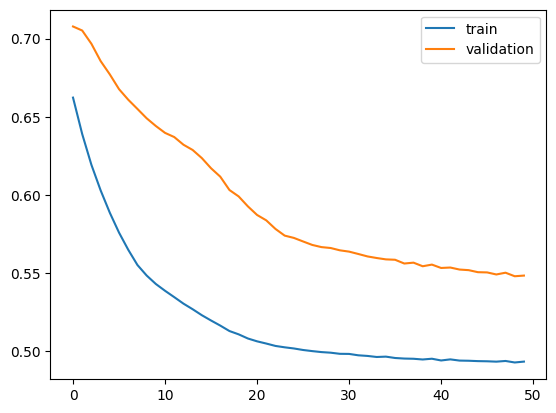

4/4 [==============================] - 0s 2ms/step


Value
Metric          
MAE    73,116.01
RMSE   93,107.12
R2         -0.44

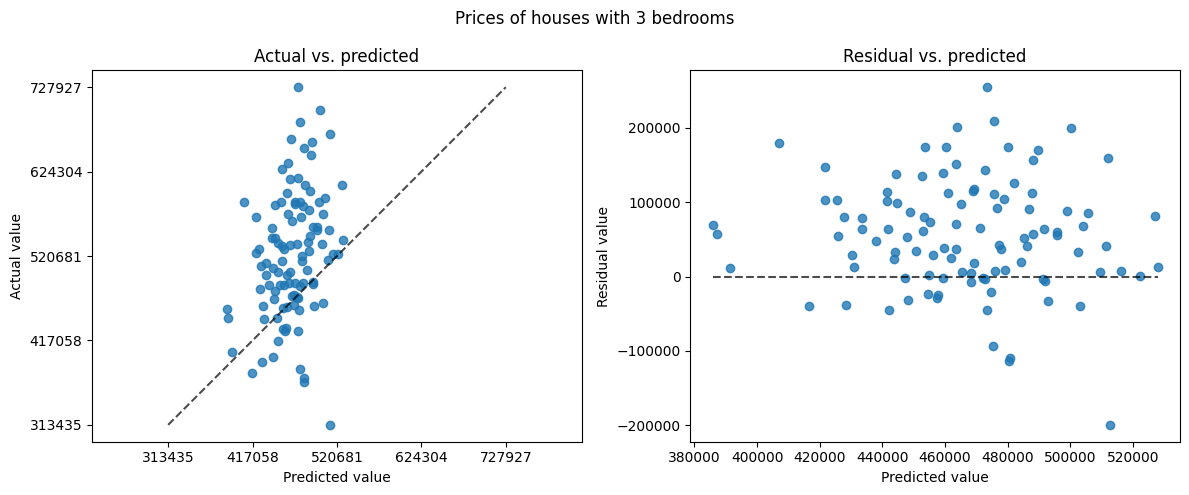

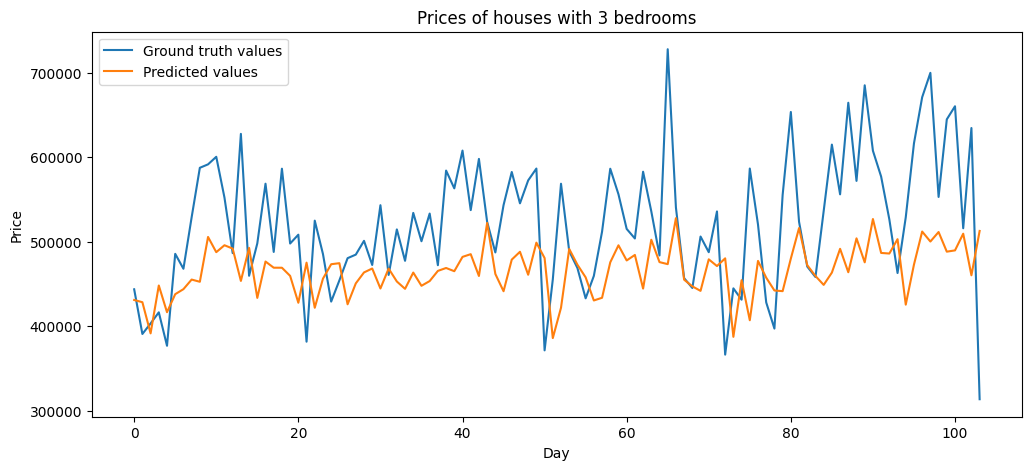

In [131]:
main(df_b, df_b_test, config)

#### Week lag 2
At first, we configured the resampling on a week basis. We tried several lag windows. we tried `n_lag = 1` up to `n_lag = 6`; these are our observations:

* the more the `n_lag` value grows,
* the lower the training loss,
* the larger `val_loss - train_loss`
* other metrics are comparable

In the end we kept `n_lag=2` for the rest of our experiments.

In [132]:
config = ModelConfiguration(
    n_lag=2,
)

asdict(config)

{'resampling_window': 'W',
 'scaler': 'robust',
 'n_lag': 2,
 'handle_outliers': None,
 'outliers_threshold': 2000000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mae',
 'optimizer': 'sgd',
 'learning_rate': 0.001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.0,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': None,
 'recurrent_regularizer': None}

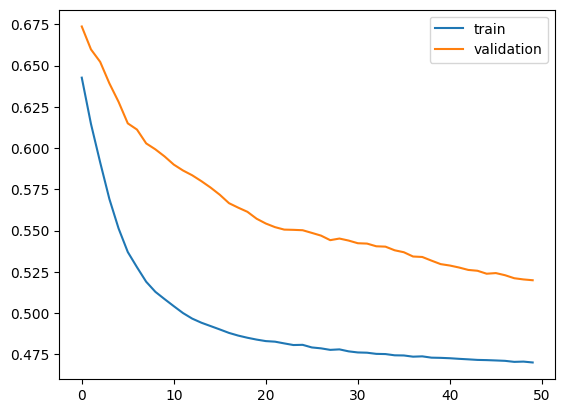

4/4 [==============================] - 0s 2ms/step


Value
Metric          
MAE    70,327.97
RMSE   89,685.26
R2         -0.29

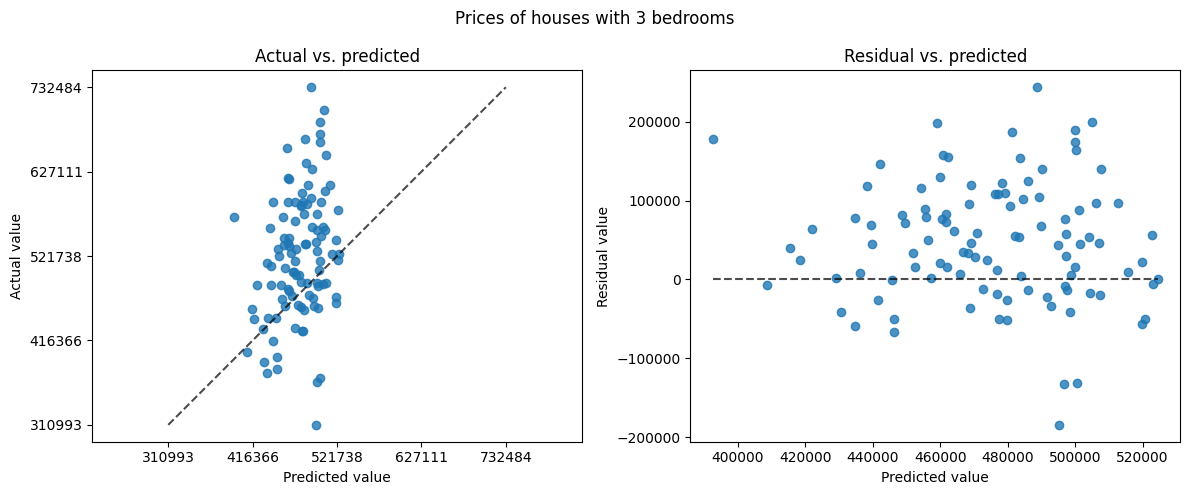

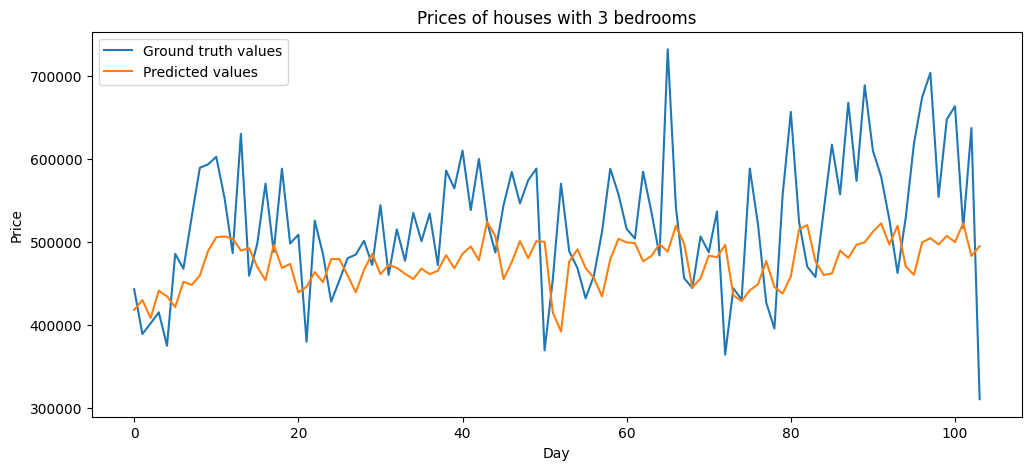

In [133]:
main(df_b, df_b_test, config)

#### MSE

As second parameter, we tried to use MSE as training loss over MAE, as the former is more robust than the latter. Indeed, this change in the loss functions had a noticeable impact in the shape of the training loss.

In [134]:
config = ModelConfiguration(
    n_lag=2,
    loss="mse"
)

asdict(config)

{'resampling_window': 'W',
 'scaler': 'robust',
 'n_lag': 2,
 'handle_outliers': None,
 'outliers_threshold': 2000000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'sgd',
 'learning_rate': 0.001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.0,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': None,
 'recurrent_regularizer': None}

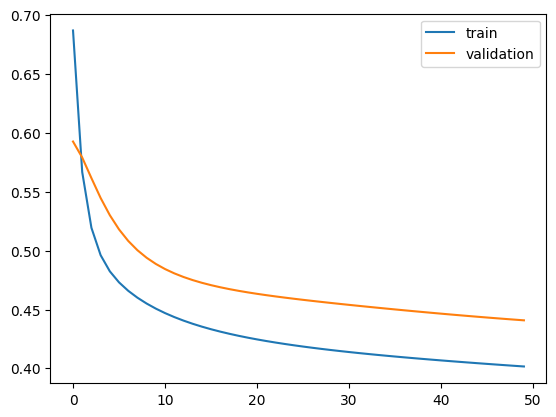

4/4 [==============================] - 0s 3ms/step


Value
Metric          
MAE    70,672.45
RMSE   89,830.80
R2         -0.29

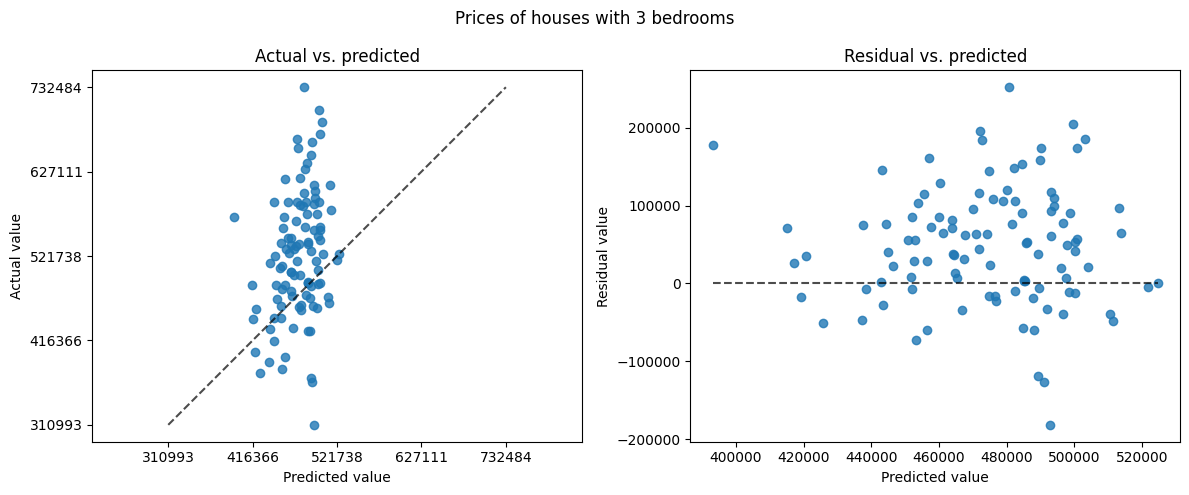

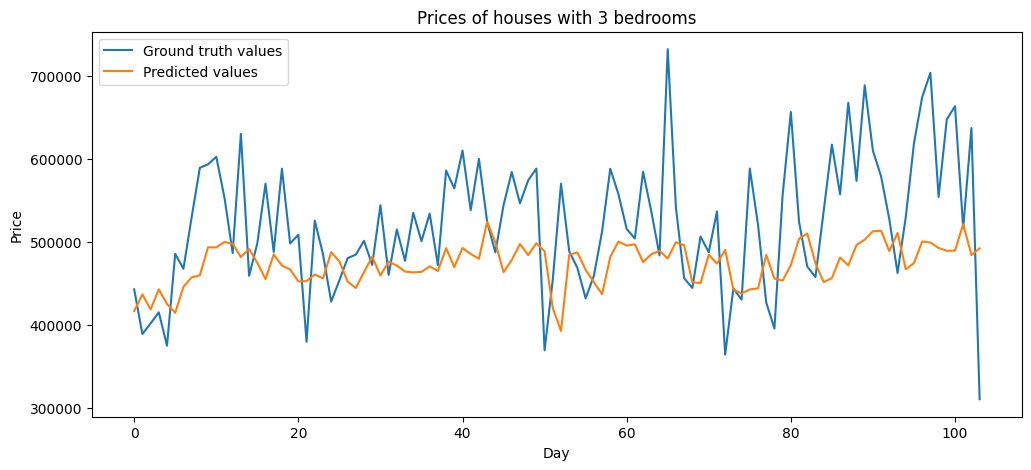

In [135]:
main(df_b, df_b_test, config)

#### Adam LR = 0.0001

We then considered the choice of optimizer. For the first experiments, we were using SGD; now we are trying Adam, as it should provide us with faster convergence. 

At first, we tried to keep the same `learning_rate` we were using before `lr=0.003`, but that turned out to be too agressive and the model severly overfitted after the 20th epoch. After some experiments, we settled on `lr=0.0001`; with this configuration, we we can see from the progression of the validation loss that we are reducing overfitting on the validation set. We also tried to use an `scheduler`, specifically the `ExponentialDecay` with `decay_rate=0.9`, but that turned out to be too aggressive.

In the end, we decided to keep Adam with `learning_rate=0.0001` as configuration.

In [136]:
config = ModelConfiguration(
    n_lag=2,
    loss="mse",
    optimizer="adam",
    learning_rate=1e-4,
    # lr_scheduler=True
)

asdict(config)

{'resampling_window': 'W',
 'scaler': 'robust',
 'n_lag': 2,
 'handle_outliers': None,
 'outliers_threshold': 2000000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'adam',
 'learning_rate': 0.0001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.0,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': None,
 'recurrent_regularizer': None}

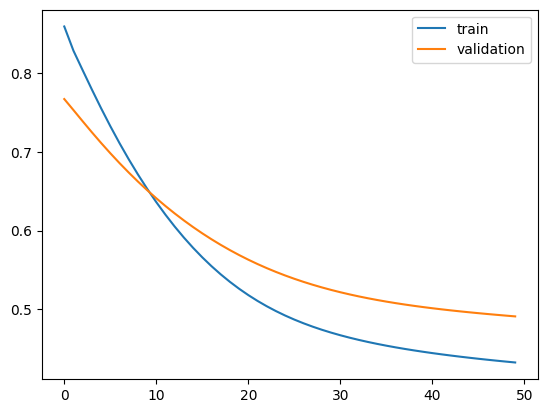

4/4 [==============================] - 0s 2ms/step


Value
Metric          
MAE    75,347.53
RMSE   94,779.85
R2         -0.44

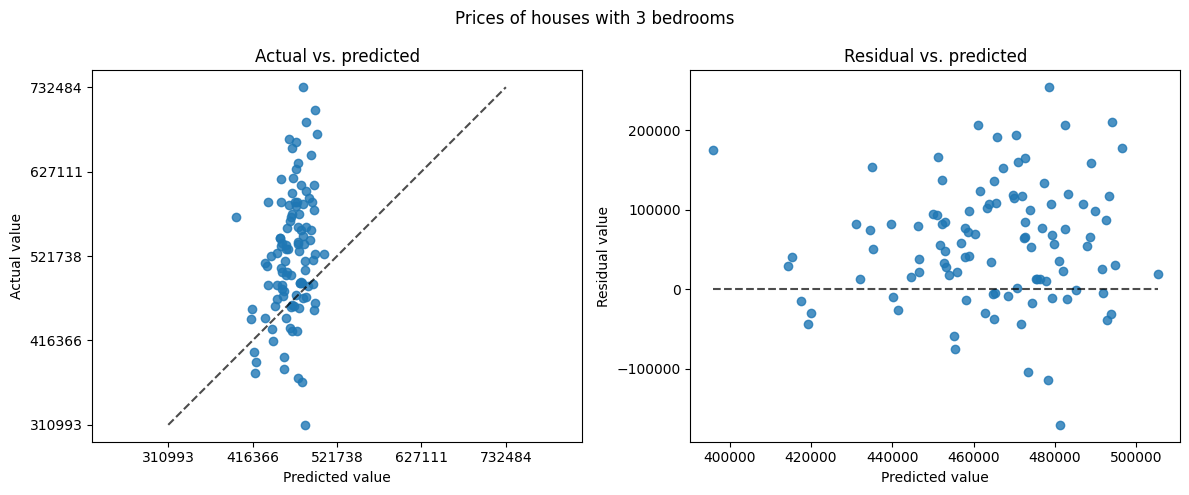

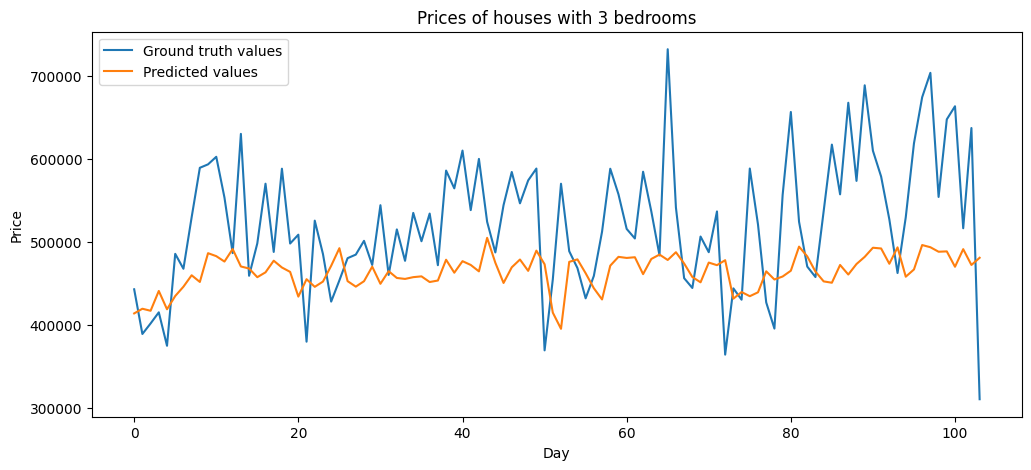

In [137]:
main(df_b, df_b_test, config)

#### GRU 

Next, we moved our attention to the cell architecture of the RNN. Previously, we were using LSTM cells; now, we are trying GRU, as their simpler architecture may ensure faster training time and better performances. From our experiments, the results are pretty similar; this is probably due to the fact that the size of the problem is not large enough to justify different performances of one cell model over the other.

We decided to keep using LSTMs, as GRU did not provide any significant improvement.

We also tried to tweak the number of units of the recurrent layer up to *400*, but unfortunately this had almost no impact on the model performances.

In [138]:
config = ModelConfiguration(
    n_lag=2,
    loss="mse",
    optimizer="adam",
    learning_rate=1e-4,
    model="gru",
    # bidirectional=True,
    # units=400    
)

asdict(config)

{'resampling_window': 'W',
 'scaler': 'robust',
 'n_lag': 2,
 'handle_outliers': None,
 'outliers_threshold': 2000000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'gru',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'adam',
 'learning_rate': 0.0001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.0,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': None,
 'recurrent_regularizer': None}

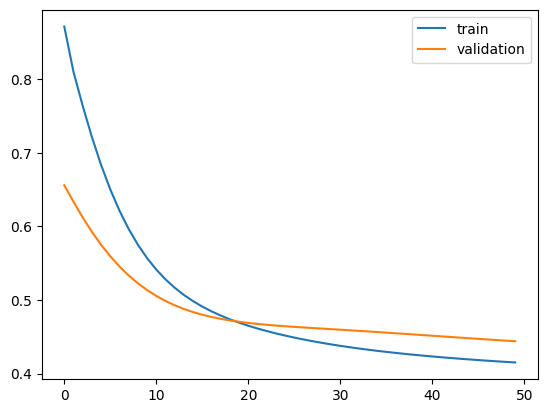

4/4 [==============================] - 0s 3ms/step


Value
Metric          
MAE    70,905.08
RMSE   90,148.92
R2         -0.30

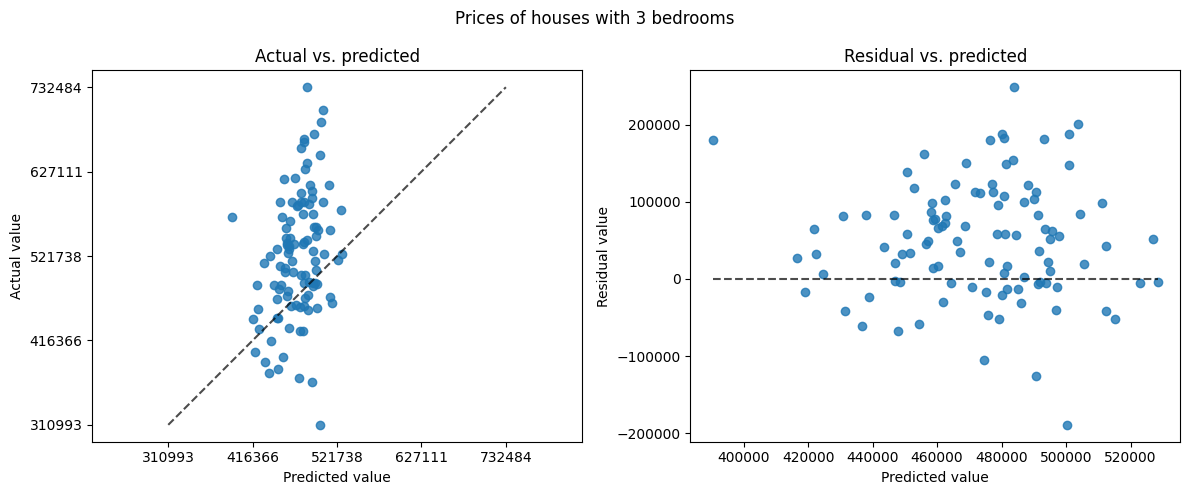

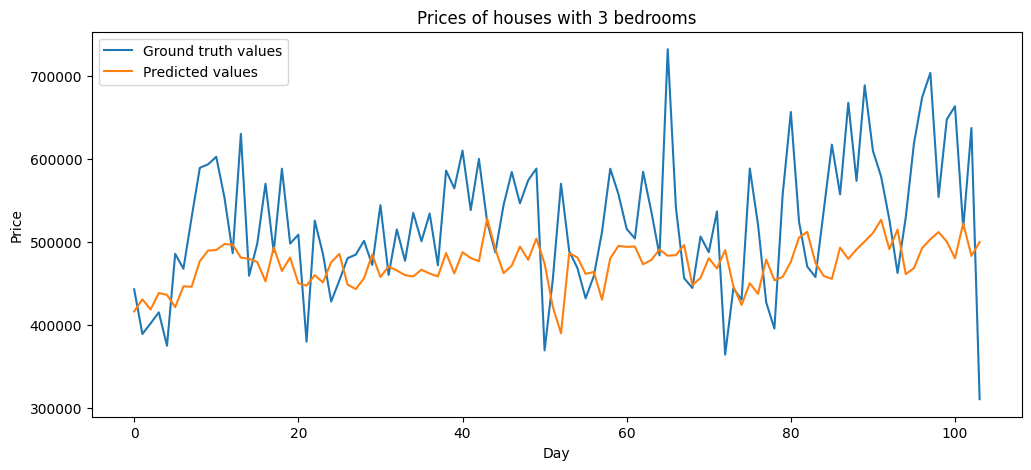

In [139]:
main(df_b, df_b_test, config)

#### Dropout + L2 regularization

We are now employing regularization to reduce overfitting and improving the generalizationof the model.

Applying `dropout` with `p=0.5` to the output of the recurrent layer helped controlling the growth of the validation loss; conversely, applying `dropout` between the timesteps of the recurrent layer resulted in more overfitting in our experiments (we tried `p=0.5` and `p=0.3`).

However, the usage of `dropout` caused the training loss to be have an inconsistent pattern. We tried to use *L2* regularization, which helped to keep the validation loss below `0.6`, even after 100 epochs of training.

This configuration resulted in slighlty worse values of RMSE and MAE, but that can be a fair price to pay for having more generalization.

In [140]:
config = ModelConfiguration(
    n_lag=2,
    loss="mse",
    learning_rate=1e-4,
    optimizer="adam",
    dropout=.5,
    # recurrent_dropout=.3
    kernel_regularizer="l2",
    recurrent_regularizer="l2",
    epochs=100
)

asdict(config)

{'resampling_window': 'W',
 'scaler': 'robust',
 'n_lag': 2,
 'handle_outliers': None,
 'outliers_threshold': 2000000,
 'epochs': 100,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'adam',
 'learning_rate': 0.0001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.5,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': 'l2',
 'recurrent_regularizer': 'l2'}

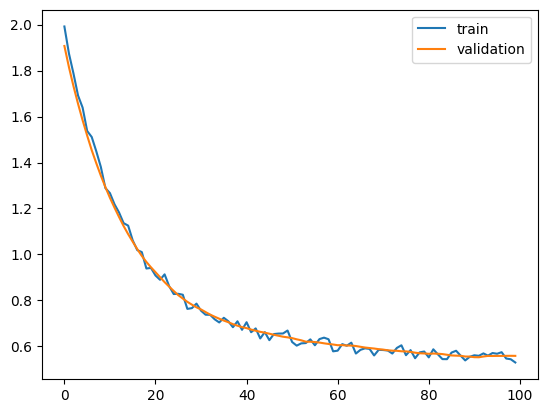

4/4 [==============================] - 0s 3ms/step


Value
Metric          
MAE    74,953.38
RMSE   93,878.47
R2         -0.41

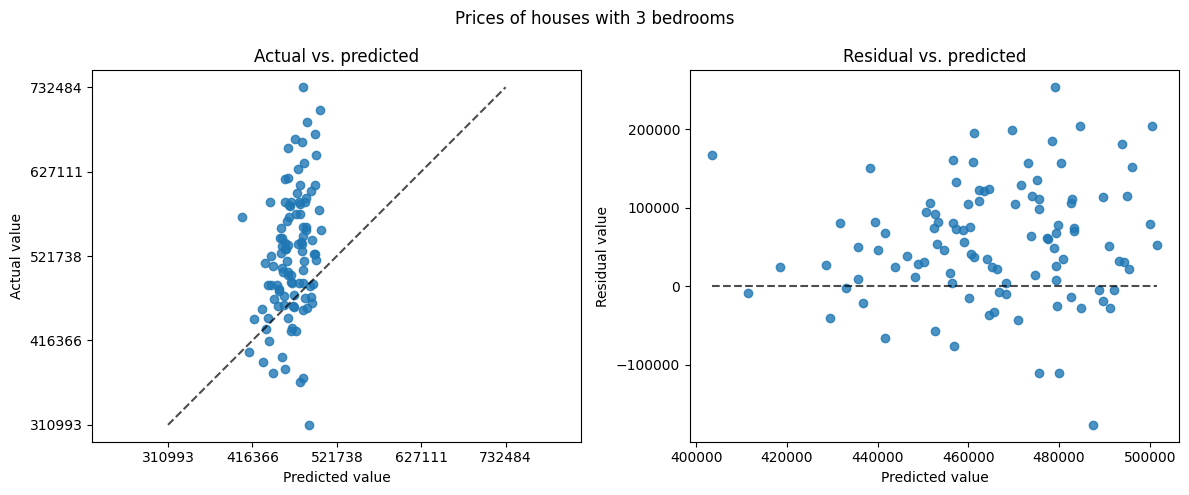

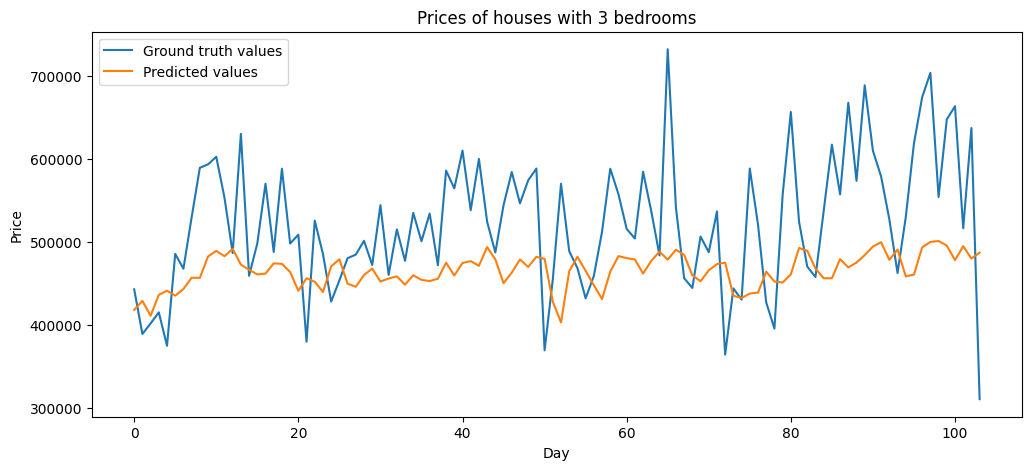

In [141]:
main(df_b, df_b_test, config)

#### ReLU + SoftMax

As one last model configuration parameter, we tried to use different activation functions; specifically, we used ReLU between timesteps of the recurrent layer, and Softmax for the output of the recurrent layer (which will then feed the final fully connected layer). These changes destroyed the results: the validation loss reveals severe overfitting, we got + 30 in RMSE and the plots of predictions against ground truth simply reveals that the model was not properly trained. 

In [142]:
config = ModelConfiguration(
    n_lag=2,
    loss="mse",
    optimizer="adam",
    dropout=.5,
    kernel_regularizer="l2",
    activation="softmax",
    recurrent_activation="relu"
)

asdict(config)

{'resampling_window': 'W',
 'scaler': 'robust',
 'n_lag': 2,
 'handle_outliers': None,
 'outliers_threshold': 2000000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'adam',
 'learning_rate': 0.001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'softmax',
 'recurrent_activation': 'relu',
 'dropout': 0.5,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': 'l2',
 'recurrent_regularizer': None}

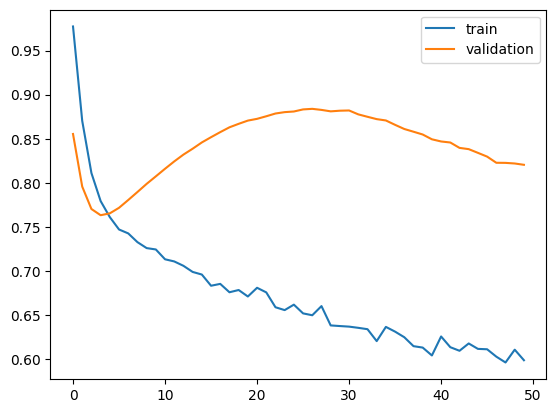

4/4 [==============================] - 0s 2ms/step


Value
Metric           
MAE     99,251.39
RMSE   118,955.38
R2          -1.27

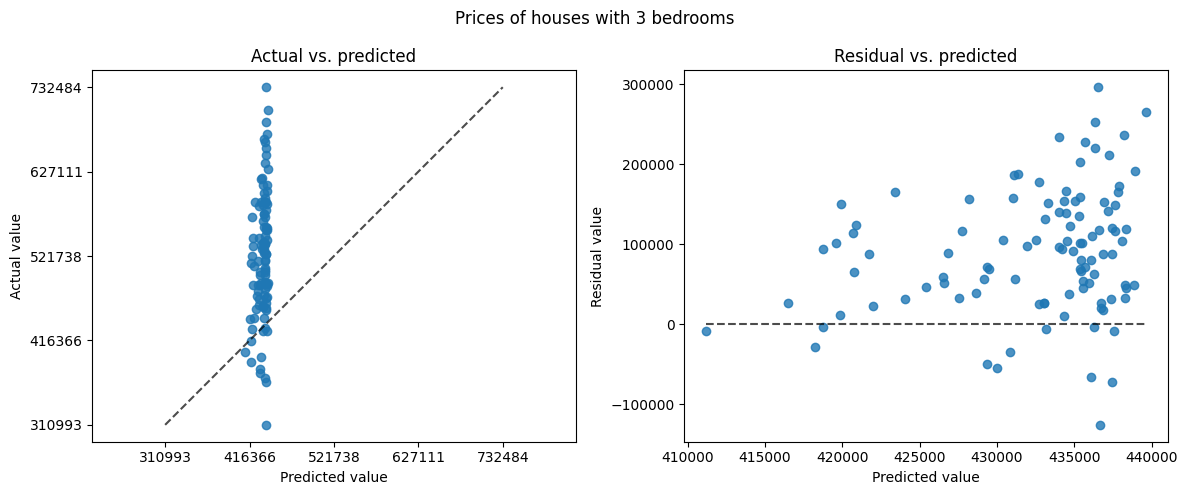

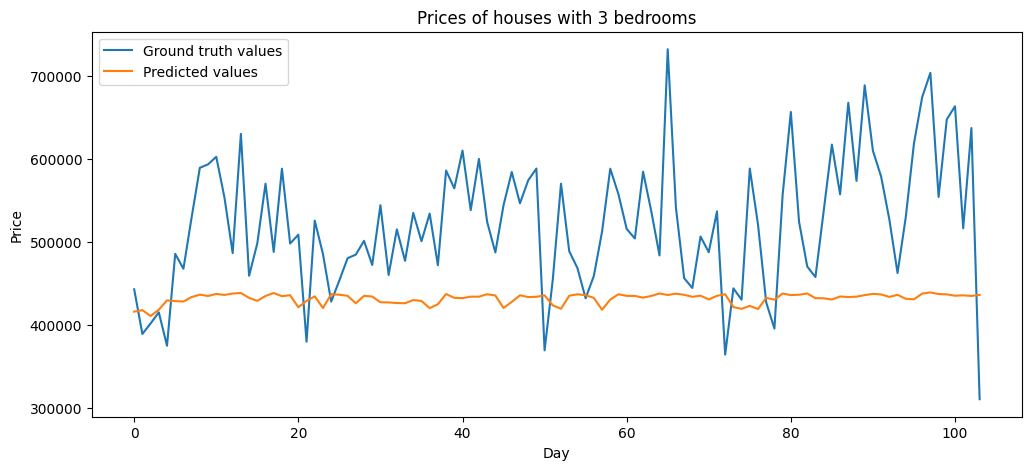

In [143]:
main(df_b, df_b_test, config)

#### No outliers

At this point, we were disappointed in the performances of the model. Recalling the fact that there are many outliers in the training set, we decided to try several techniques for dealing with them, as explained before.

The first technique we tried is simply *pruning* them. We experimented with several pruning thresholds, specifically:

* 4,000,000: no noticeable difference  in performances
* 3,000,000: noticeable gain in metrics (-10 RMSE, -6 MAE)
* 2,000,000: comparable to the previous bullet
* 1,000,000: severe gain in metrics (-30 RMSE, -20 MAE)
* 600,000: further gain (-40 RMSE, -20 MAE)


In [144]:
config = ModelConfiguration(
    handle_outliers="remove",
    outliers_threshold=1000000,
    n_lag=2,
    loss="mse",
    optimizer="adam",
    learning_rate=1e-4,
    dropout=.5,
    kernel_regularizer="l2",
)

asdict(config)

{'resampling_window': 'W',
 'scaler': 'robust',
 'n_lag': 2,
 'handle_outliers': 'remove',
 'outliers_threshold': 1000000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'adam',
 'learning_rate': 0.0001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.5,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': 'l2',
 'recurrent_regularizer': None}

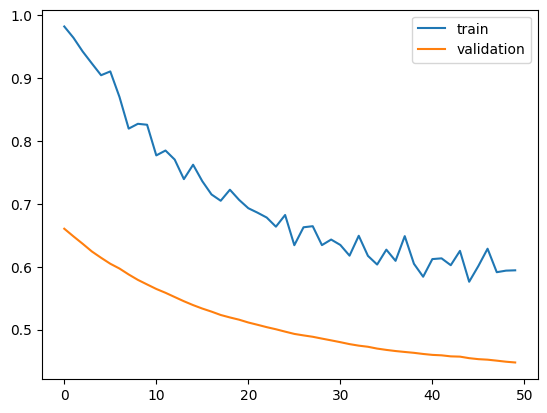

4/4 [==============================] - 1s 3ms/step


Value
Metric          
MAE    44,957.73
RMSE   57,655.62
R2         -0.29

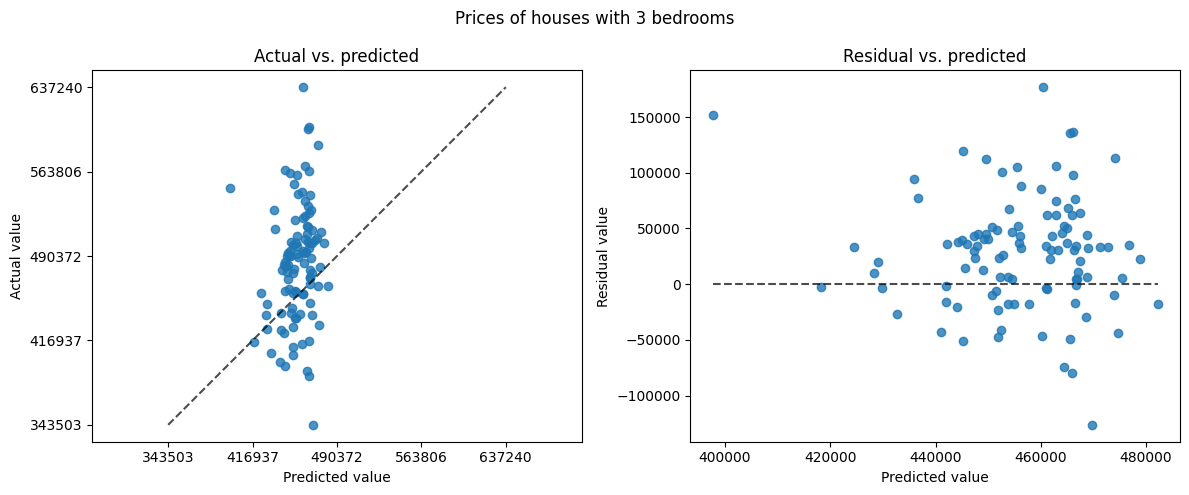

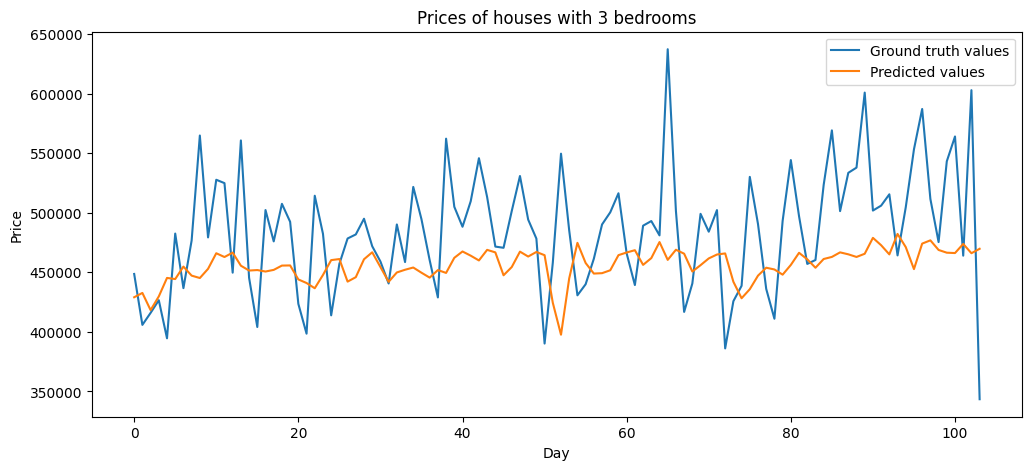

In [145]:
main(df_b, df_b_test, config)

#### MinMax normalization

Up until this point, we have always used the `RobustScaler`, as it is most suited with data that feature outliers. We are now trying to use the `MinMaxScaler` in the trimmed dataset. We obtained lower values for RMSE and MAE but $R^2$ shows worse performances; moreover, the predicted against ground truth line plot appears to show worst fitting. We decided to keep using the `RobustScaler`.

In [146]:
config = ModelConfiguration(
    handle_outliers="remove",
    outliers_threshold=1000000,
    n_lag=2,
    loss="mse",
    learning_rate=1e-4,
    optimizer="adam",
    dropout=.5,
    scaler="minmax"
)

# Observation
# results are clearly off, this is not a good scaler

asdict(config)

{'resampling_window': 'W',
 'scaler': 'minmax',
 'n_lag': 2,
 'handle_outliers': 'remove',
 'outliers_threshold': 1000000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'adam',
 'learning_rate': 0.0001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.5,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': None,
 'recurrent_regularizer': None}

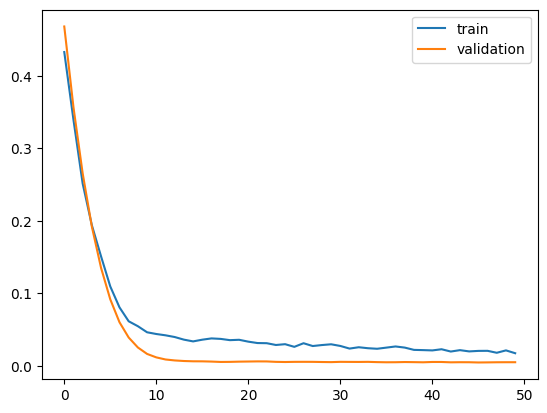

4/4 [==============================] - 0s 3ms/step


Value
Metric          
MAE    28,205.75
RMSE   35,213.21
R2         -0.54

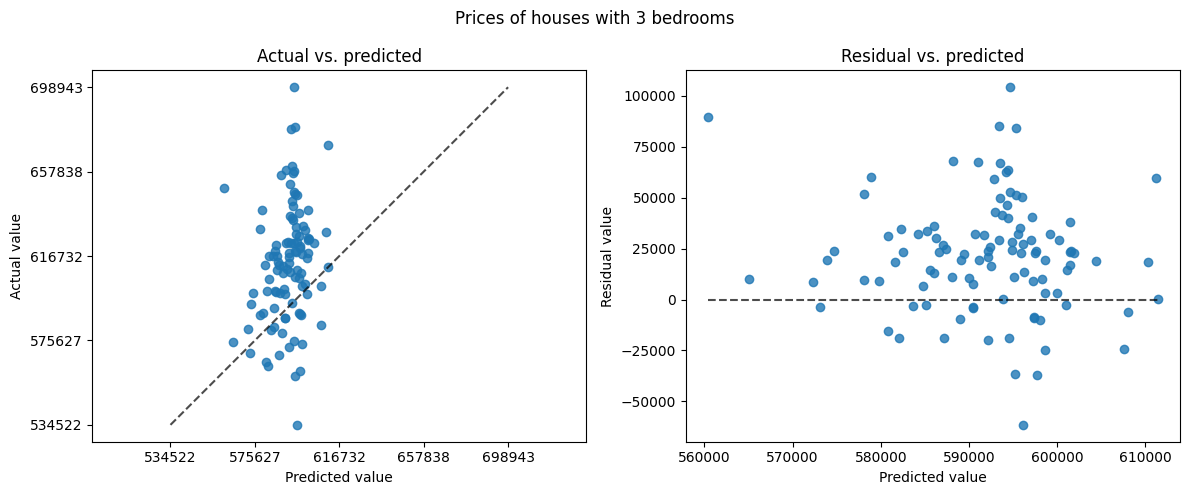

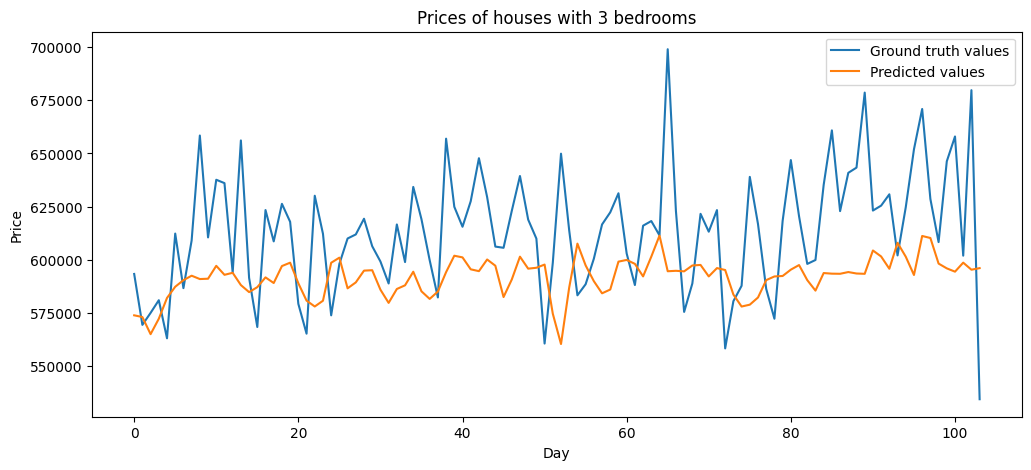

In [147]:
main(df_b, df_b_test, config)

#### Capping outliers

Encoureged by the good results of the experiments with the trimming of outliers, we tried to apply less aggressive techniques for handling the outliers; specifically, we substitute them with (i) the value of the 75% quantile and (ii) the mean. Both of them resulted in poor results compared to trimming.

In [148]:
config = ModelConfiguration(
    handle_outliers="75percent",
    outliers_threshold=1000000,
    n_lag=2,
    loss="mse",
    optimizer="adam",
    learning_rate=1e-4,
    dropout=.5,
    kernel_regularizer="l2",
)

asdict(config)

{'resampling_window': 'W',
 'scaler': 'robust',
 'n_lag': 2,
 'handle_outliers': '75percent',
 'outliers_threshold': 1000000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'adam',
 'learning_rate': 0.0001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.5,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': 'l2',
 'recurrent_regularizer': None}

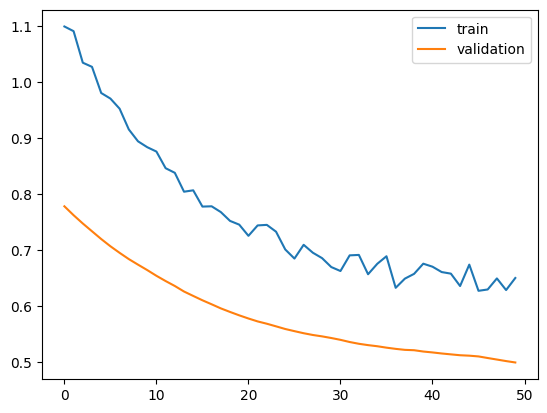

4/4 [==============================] - 0s 2ms/step


Value
Metric          
MAE    55,118.53
RMSE   69,672.55
R2         -0.38

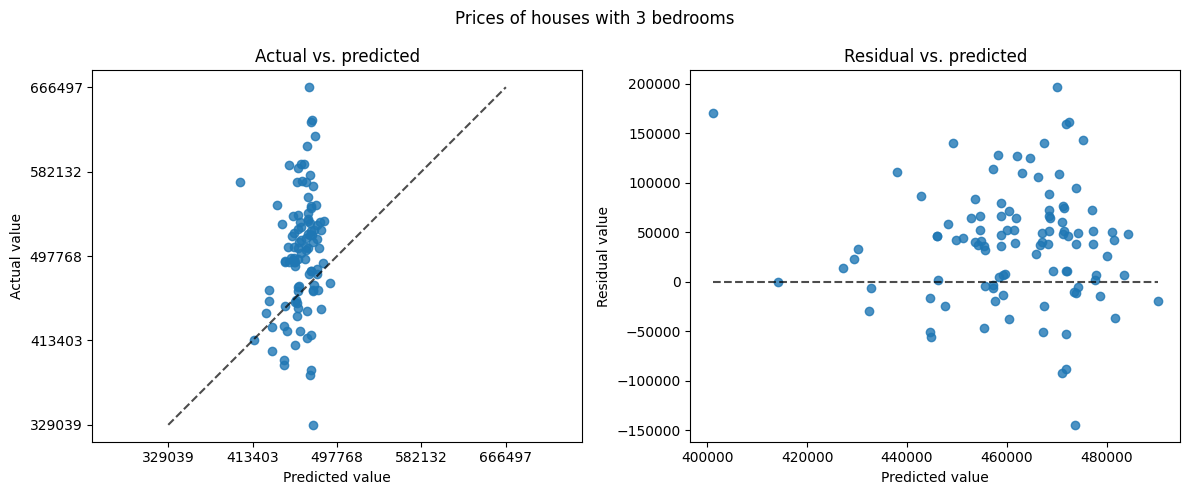

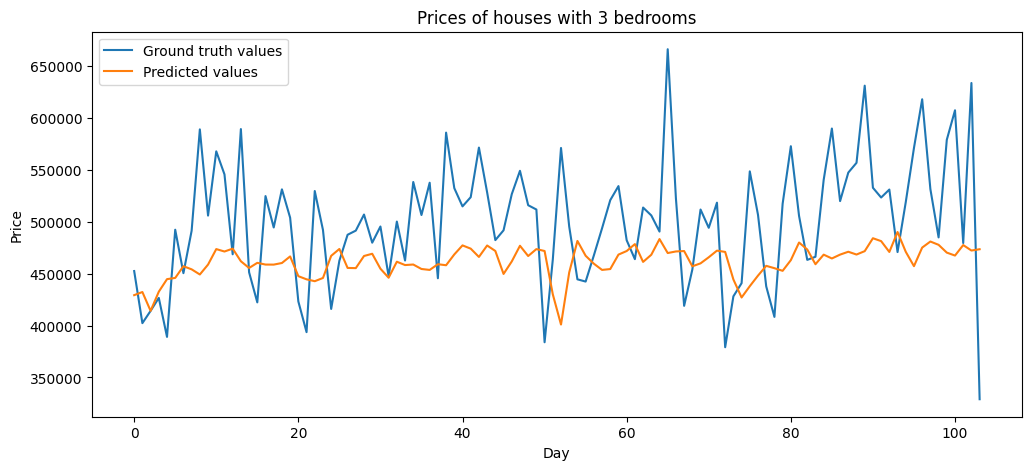

In [149]:
main(df_b, df_b_test, config)

#### Days time-series

We are experimenting with different resampling configuration. It may be the case, in fact, that the *week* resampling prevents the model from training properly. We decided to experiment with *days* time-series. Specifically, we tried the following configurations:

1. D (one day), `n_lag` = 3 
2. D (one day), `n_lag` = 7 
3. D (one day), `n_lag` = 15 
4. D (one day), `n_lag` = 30 
5. 3D (three day), `n_lag` = 2 (6 days) 
6. 3D (three day), `n_lag` = 4 (12 days) 

In the end, configuration (2) granted us with the best results

In [169]:
config = ModelConfiguration(
    resampling_window="D",
    n_lag=7,
    loss="mse",
    optimizer="adam",
    learning_rate=1e-4,
    dropout=.5,
    kernel_regularizer="l2",
    recurrent_regularizer="l2",
)

# Observation
# 1D looks pretty good
# 3D worse, discarded

asdict(config)

{'resampling_window': 'D',
 'scaler': 'robust',
 'n_lag': 7,
 'handle_outliers': None,
 'outliers_threshold': 2000000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'adam',
 'learning_rate': 0.0001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.5,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': 'l2',
 'recurrent_regularizer': 'l2'}

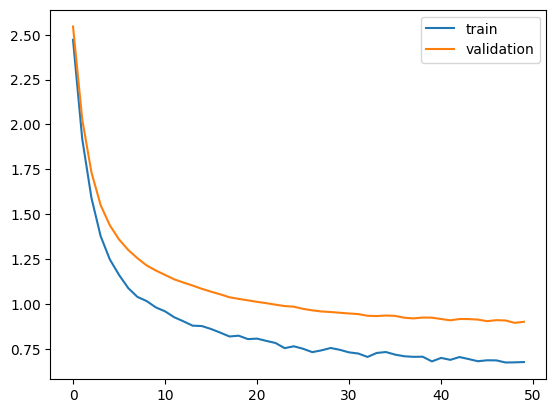

23/23 [==============================] - 1s 4ms/step


Value
Metric           
MAE     76,547.61
RMSE   103,317.23
R2           0.03

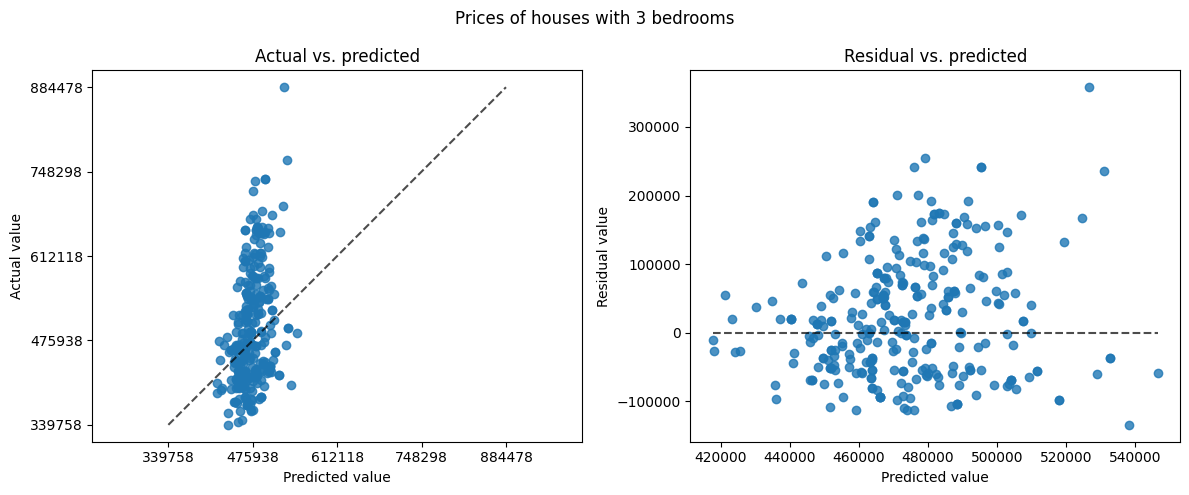

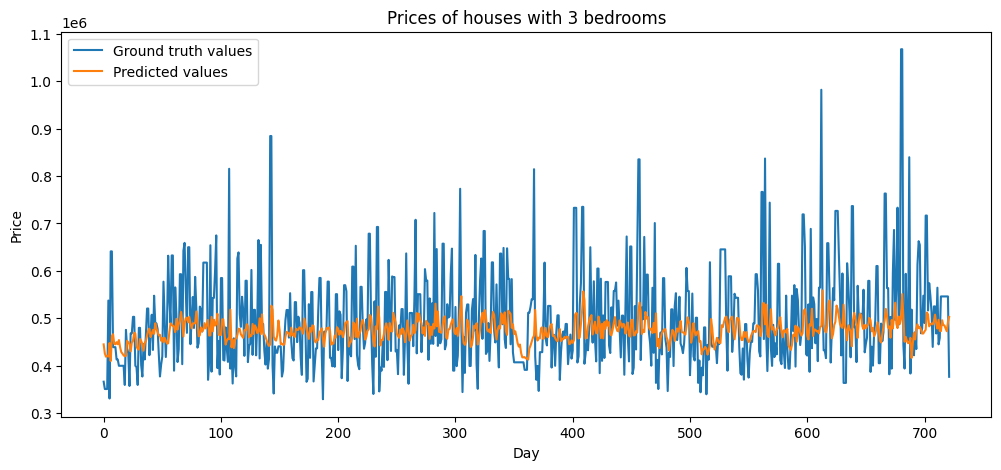

In [170]:
main(df_b, df_b_test, config)

#### Days + No outliers

Encouraged by the previous result, we are now trying the resampling configuration (`"D"`, `n_lag` = 7) also on the trimmed dataset. As expected, we are getting a nice boost in performances with respect to the untrimmed dataset.

In [171]:
config = ModelConfiguration(
    resampling_window="D",
    n_lag=7,
    loss="mse",
    optimizer="adam",
    learning_rate=1e-4,
    dropout=.5,
    kernel_regularizer="l2",
    recurrent_regularizer="l2",
    handle_outliers="remove",
    outliers_threshold=600000
)

# Observation
# restricting range of prediction up to 600000 allows us to have a nice model

asdict(config)

{'resampling_window': 'D',
 'scaler': 'robust',
 'n_lag': 7,
 'handle_outliers': 'remove',
 'outliers_threshold': 600000,
 'epochs': 50,
 'batch_size': 16,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'adam',
 'learning_rate': 0.0001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.5,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': 'l2',
 'recurrent_regularizer': 'l2'}

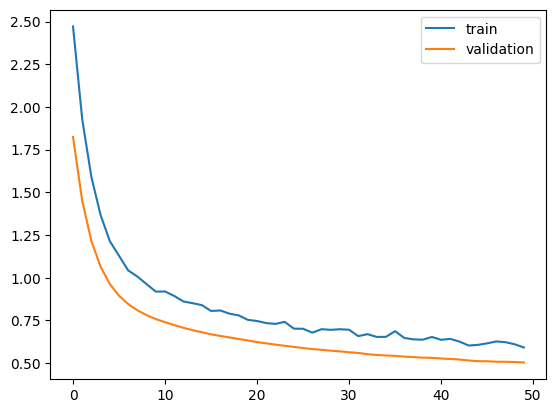

23/23 [==============================] - 1s 3ms/step


Value
Metric          
MAE    35,244.39
RMSE   44,004.05
R2         -0.07

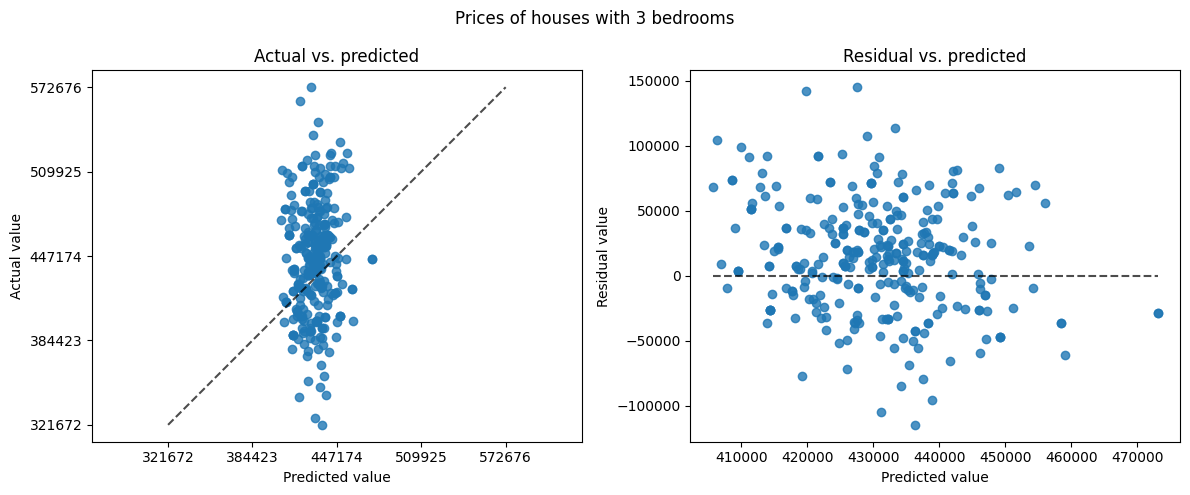

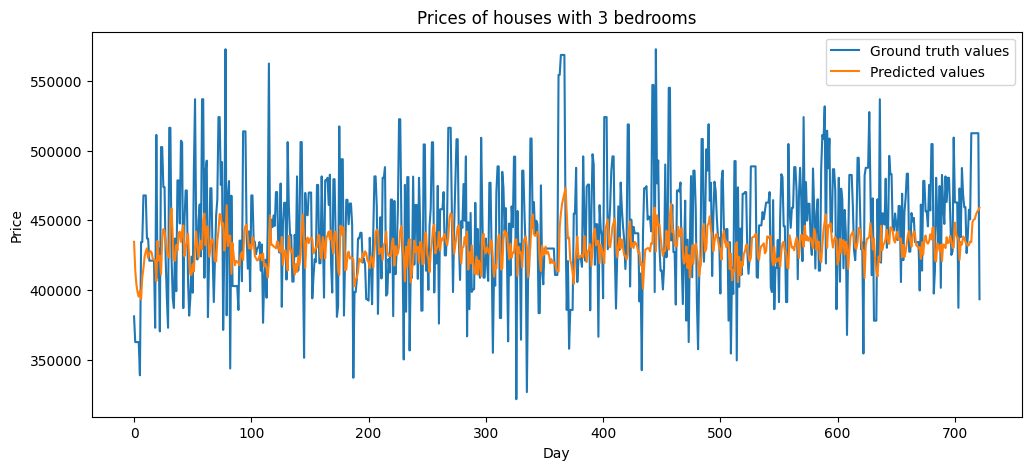

In [172]:
main(df_b, df_b_test, config)

#### No regularization

As final attempt, we tried to remove the regularizers (`dropout` and L2) to see if their beneficial impact is still there. We found that, without those regularizers, the output range is slightly widened, as if the model were less cautious in its predictions and more prone to output  larger and smaller values. 

In [154]:
config = ModelConfiguration(
    resampling_window="D",
    n_lag=7,
    loss="mse",
    optimizer="adam",
    learning_rate=1e-4,
    # dropout=.5,
    # kernel_regularizer="l2",
    # recurrent_regularizer="l2",
    handle_outliers="remove",
    outliers_threshold=600000,
    batch_size=64
)

# Observation
# increases batch size leads to less overfitting

asdict(config)

{'resampling_window': 'D',
 'scaler': 'robust',
 'n_lag': 7,
 'handle_outliers': 'remove',
 'outliers_threshold': 600000,
 'epochs': 50,
 'batch_size': 64,
 'verbose': 0,
 'shuffle': False,
 'model': 'lstm',
 'bidirectional': False,
 'loss': 'mse',
 'optimizer': 'adam',
 'learning_rate': 0.0001,
 'lr_scheduler': False,
 'units': 100,
 'activation': 'tanh',
 'recurrent_activation': 'sigmoid',
 'dropout': 0.0,
 'recurrent_dropout': 0.0,
 'kernel_regularizer': None,
 'recurrent_regularizer': None}

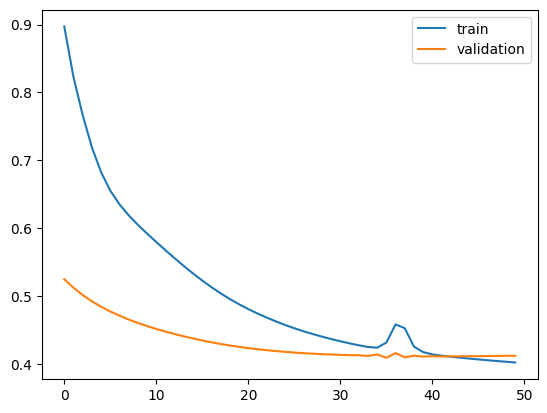

23/23 [==============================] - 0s 2ms/step


Value
Metric          
MAE    35,105.20
RMSE   43,959.29
R2         -0.07

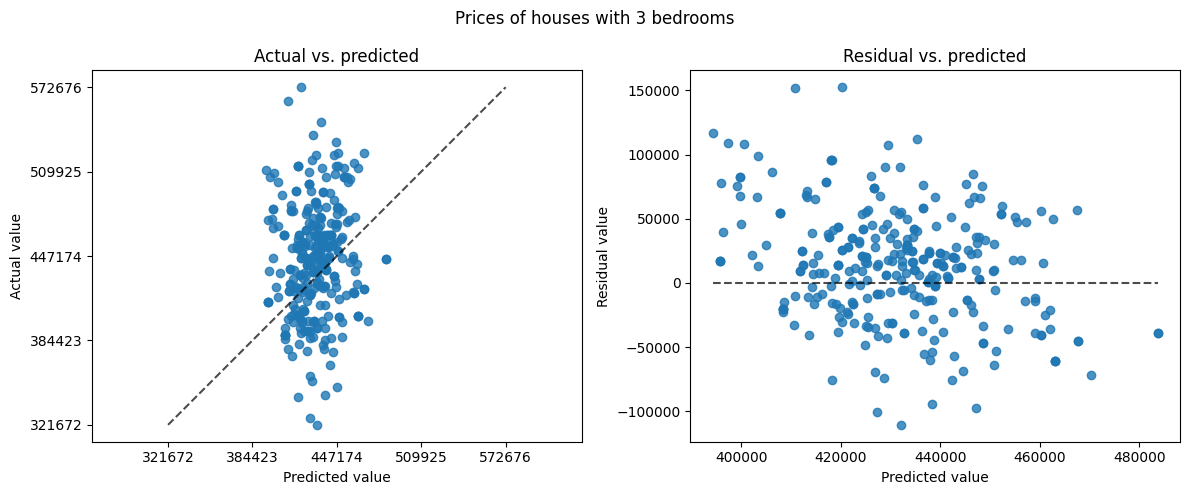

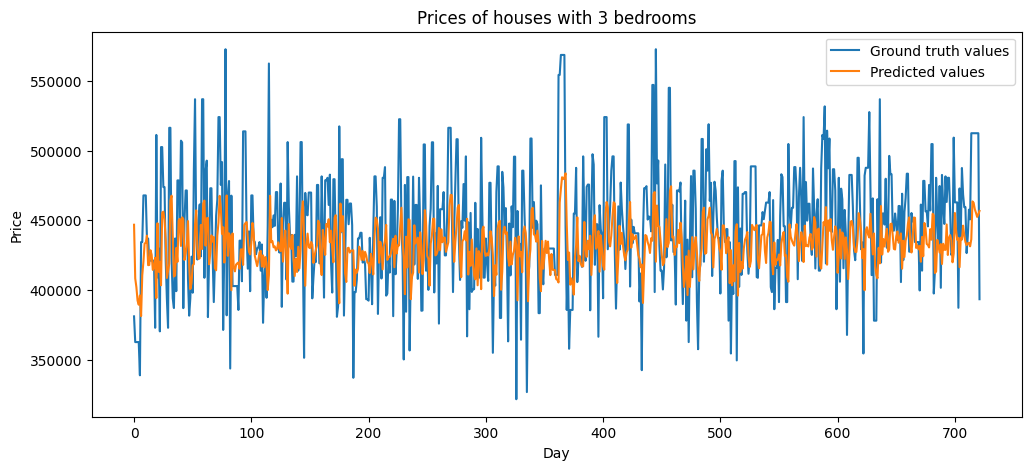

In [155]:
main(df_b, df_b_test, config)

### Final evaluation

This is our final performances for our model. The chosen configuration is the one from the *Days + No outliers* experiment, except the batch size, which is set to 64 after some more experiments and fine-tuning. 

2023-04-04 19:07:49.159792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 19:07:49.400670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 19:07:49.499375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 19:07:50.342848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 19:07:50.415924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


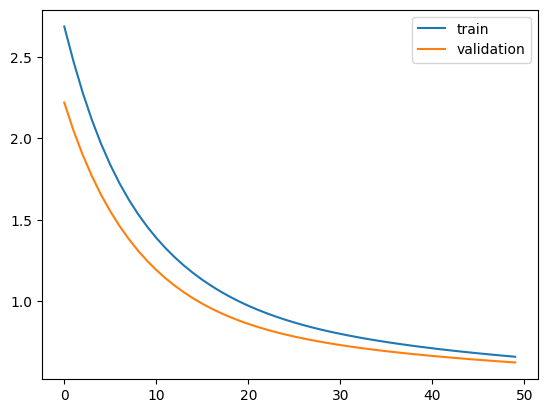

13/23 [===============>..............] - ETA: 0s

2023-04-04 19:08:11.119208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-04 19:08:11.179720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 4ms/step


Value
Metric          
MAE    35,371.15
RMSE   44,101.59
R2         -0.08

Evaluation on the test data:
30/30 [==============================] - 0s 3ms/step


Value
Metric          
MAE    38,658.68
RMSE   48,488.66
R2          0.07

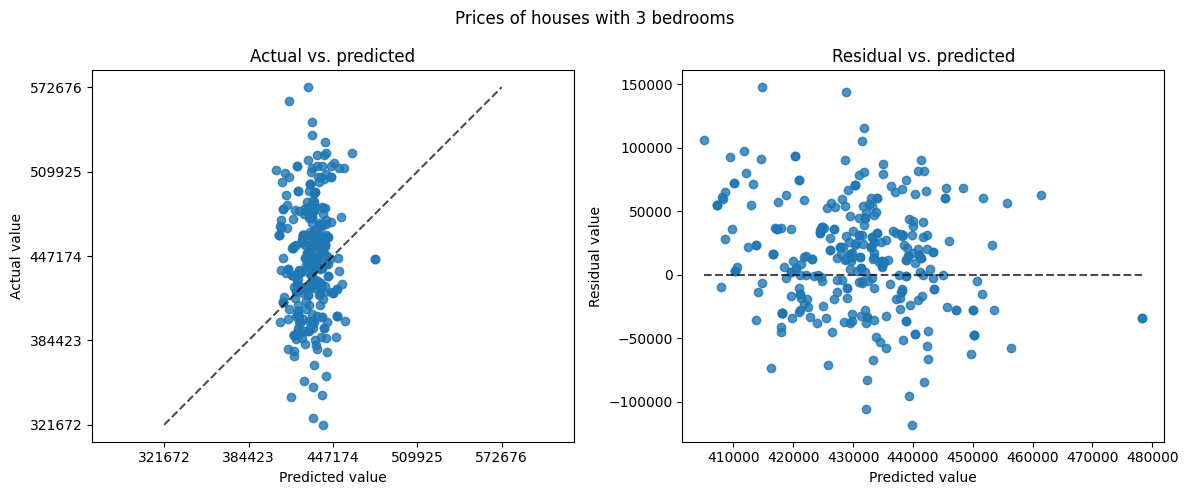

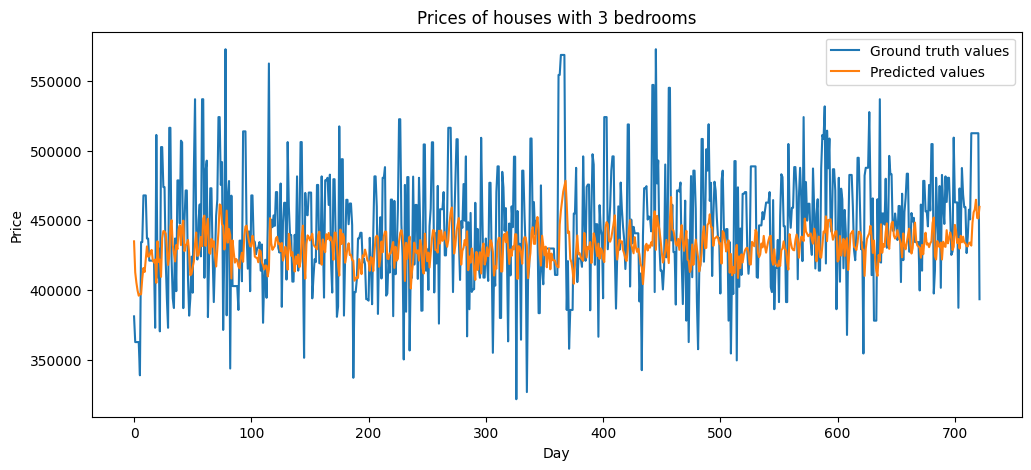

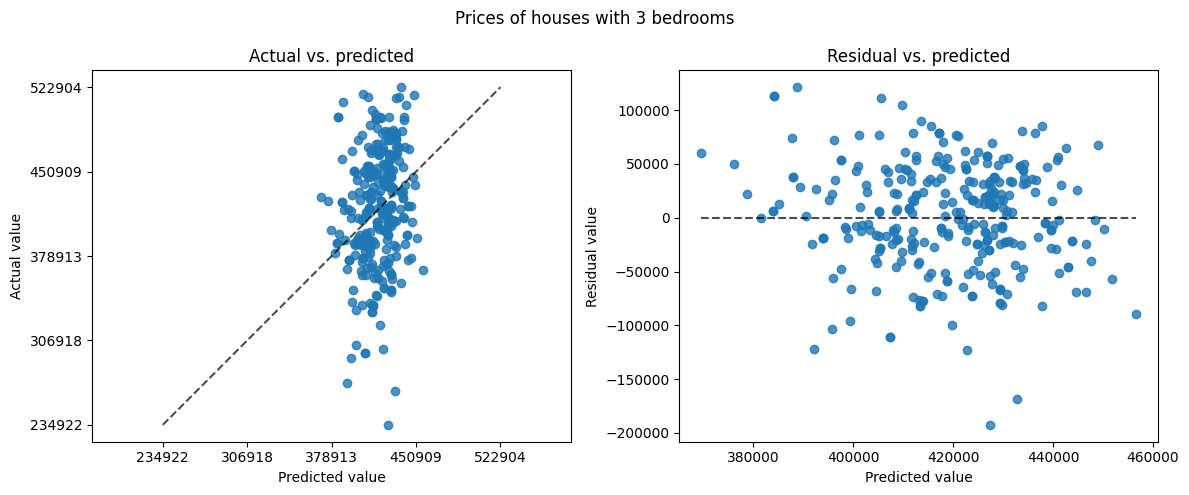

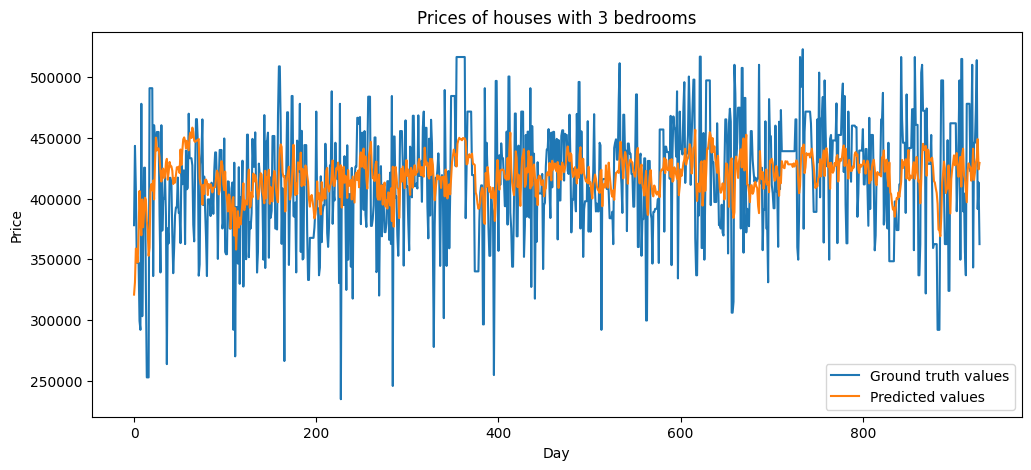

In [274]:
best_config = ModelConfiguration(
    resampling_window="D",
    n_lag=7,
    loss="mse",
    optimizer="adam",
    learning_rate=1e-4,
    dropout=.5,
    kernel_regularizer="l2",
    recurrent_regularizer="l2",
    handle_outliers="remove",
    outliers_threshold=600000,
    batch_size=64
)
# print(best_config)
model_b_predictions, model_b_labels = main(df_b, df_b_test, best_config, run_on_test=True)

## Model comparison

In [256]:
def plot_prediction_comparison(y, y_pred_A, y_pred_B):
    plt.figure(figsize=(12,5))
    plt.plot(y, label='Ground truth values')
    plt.plot(y_pred_A, label='Model A predicted values')
    plt.plot(y_pred_B, label='Model B predicted values')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Prices of houses with 3 bedrooms")
    plt.legend()

In [278]:
true_vals_df = df_test[(df_test["bedrooms"] == 3)&(df_test["type"]=="house")][["date", "price"]]
true_vals_df = true_vals_df[true_vals_df["date"] >= "2020-01-11"]
true_vals_df = true_vals_df.groupby("date").mean()
true_vals_df 

price
date                 
2020-01-12 432,000.00
2020-01-13 430,000.00
2020-01-15 900,000.00
2020-01-16 385,000.00
2020-01-17 410,000.00
...               ...
2022-07-19 455,000.00
2022-07-20 505,000.00
2022-07-22 524,000.00
2022-07-24 475,000.00
2022-07-26 470,000.00

[530 rows x 1 columns]

In [281]:
all_dates = data_resampling(data_transform(data_cleaning(df_test)), "D").index[8:].to_numpy()
true_dates = true_vals_df.index.to_numpy()

date_mask = np.array([True if date in true_dates else False for date in all_dates])
date_mask.shape

(929,)

In [268]:
model_a_predictions = finalModelA(df_test, df_train)

/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/fluffy/erasmus/data-driven-AI/Assignment/venv/lib/python3.9/si

MAE:76435.05826028263
RMSE: 108886.96701021706
R2: 0.007417881590021658


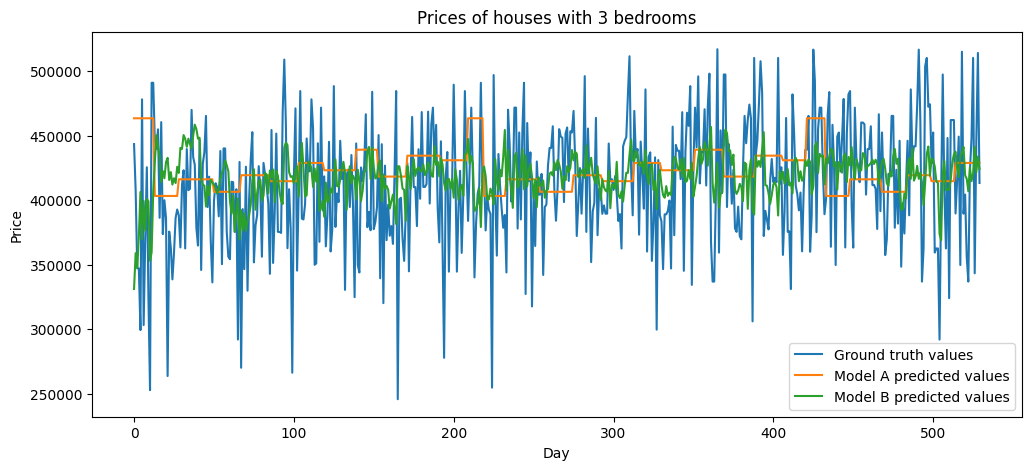

In [291]:
# Model A predictions
y_pred_A = model_a_predictions.values[2:]

# Model B predictions
y_pred_B = model_b_predictions[date_mask]

# True values
y = model_b_labels[date_mask]

plot_prediction_comparison(y, y_pred_A, y_pred_B)

# Summary

## Model A

Here we are summarizing all the require information regarding Model A. 

Please note that this is a self-contained but *not exhaustive section*; its purpose is to give a general overview of the final model we build and the main steps involved. The requested details are to be found in the [Full implementation](#full-implementation) section of Model A.

### A1

> Perform all data pre-processing steps needed for model A (i.e., integration, cleaning, reduction, and transformation). 

The main pre-processing steps we are operating in our final model are the following:

* *analysis*: we display some plots for the price in each dataset and a correlation heatmap to determine the outliers
* *cleaning*: after determining the outliers in the analysis we do a data cleaning by removing the properties with `no bedrooms` and with a price higher than a million (`price > 1000000`)

Cleaning

In [ ]:
data_cleaning(df)

In [ ]:
data_cleaning(df_test)

### A2


>In a separate markdown cell, summarize which features you create and their meaning. Motivate your strategy for creating these features.

We create new different features based on the ones given in the file:

1. The mean price per bedroom
2. The price scaled
3. The mean price per bedroom of the previous entry
4. The mean price per bedroom shifted by 2
5. The mean price per bedroom shifted by 3
6. The delta between the relevant mean bedroom price and the mean bedroom price of the previous entry
7. The bedrooms scaled
8. The mean price per bedroom scaled
9. The mean price per bedroom of the previous entry scaled
10. The delta between the relevant mean bedroom price and the mean bedroom price of the previous entry scaled
11. The mean price per month

While the the feature engineering process is essential to this task, we are aware that most of our engineered features find little to no use in the prediction, as they inherit information about the target, thus making it obsolete to use them in the regression tasks.

### A3


>Prepare your data for model selection and evaluation. What is the experimental setup that you use to build Model A? 


Our experimental setup is summarized in the following figure:

<img src="images/experimental_setup_a.jpg" width="900" class="center"/>



In order to construct our final model, we performed a number of experiments. As previously stated, the given data and the inherited features are sparse. This left us with the wish to try different regression models and approaches to ensure that the resulting predictions and performances can be compared and a reliable conclusion can be formulated. 
The selected regression models for this task are:
1. Ridge Regression
2. Linear Regression
3. Support Vector Regression
4. Decision Tree Classification
5. Random Forest Regression

In order to guarantee that all of the models are applied correctly, a hyperparameter tuning process was implemented for each model. 

* Model selection:
    * *Ridge* and *Random Forest* models use RandomSearch
    * *Linear Regression*, *Decision Tree Classification* and *Support Vector Regression* models use girdSearch
* Validation strategy:
    * Every model uses *cross-validation*
* Performance score:
    * *R2*: it depicts the similarity of predictions to the actual values

After the hyperparameter tuning is done, the best estimators and relative parameters for each model will be used for the final models and the prediction task.


### A4

>Choose a machine learning algorithm to build model A (e.g., regression, decision tree, neural network, etc.) and implement your solution. Motivate which hyperparameters you select or optimize.

As mention before, we performed various experiments to try several configurations for the model; this is due to the the fact that the choice of the best hyperparameters is mostly a matter of fine-tuning and a lot of empirical evaluation. We started by setting parameters using rule-of-thumbs in order to set a baseline and, from then, we leveraged our expertise and also some intuition for the following experiments.

In the following we are summarizing the final configuration of our model:


In [ ]:
finalModelA(df_test, df)

### A5

## Model B

Here we are summarizing all the require information regarding Model B. 

Please note that this is a self-contained but *not exhaustive section*; its purpose is to give a general overview of the final model we build and the main steps involved. The requested details are to be found in the [Full implementation](#full-implementation) section of Model B.

### B1
[//]: # (-.- .tabset)

> Perform all data pre-processing steps needed for model B (i.e., integration, cleaning, reduction, and transformation). 

The main pre-processing steps we are operating in our final model are the following:

* *reduction*: we are stripping out all `houses` with `0` and `1` bedrooms and all units with `0`, `4` and `5` bedrooms, because there are few samples of them and they are not statistically significant
* *cleaning*: we are *trimming* all the expensive properties (*outliers*) with `price > 600,000`, because outliers are sparse and difficult to predict and, from a company perspective, it makes more sense to have a model that works better for those properties in the center of the bell
* *transformation*: 
  * we are *pivoting* the table in order to create `type-bedroom` combination columns; we will use this arrangement of columns for creating lagged features later
  * we are *resampling* the table in order to convert the time-sequenced data into time-series data; for our final model, we resampled the data as *1 day* time-series
* *to supervised*: we are converting the time-series to a supervised scenario by using the `type-bedrooms` columns at a given timestep `t-`$i, \forall i, 1\le i\le$`n_lag` as feature for predicting `house-3` at timestep `t`; for our final model, we used `n_lag=7`
* *scaling*: we are normalizing the feature with scikit-learn `RobustScaler`, which removes the median and scales the data according to the quantile range

#### Reduction


In [160]:
data_cleaning(df_b)

date   price   type  bedrooms
0     2010-02-07  525000  house         4
1     2010-02-27  290000  house         3
2     2010-03-07  328000  house         3
3     2010-03-09  380000  house         4
4     2010-03-21  310000  house         3
...          ...     ...    ...       ...
19791 2019-12-23  395000   unit         3
19792 2019-12-23  408000   unit         1
19793 2019-12-23  472000   unit         2
19794 2019-12-23  570000   unit         2
19795 2019-12-23  615000   unit         3

[19680 rows x 4 columns]

#### Handle outliers

In [161]:
handle_outliers(data_cleaning(df_b), "remove", 600000)

date   price   type  bedrooms
0     2010-02-07  525000  house         4
1     2010-02-27  290000  house         3
2     2010-03-07  328000  house         3
3     2010-03-09  380000  house         4
4     2010-03-21  310000  house         3
...          ...     ...    ...       ...
19790 2019-12-23  350000   unit         2
19791 2019-12-23  395000   unit         3
19792 2019-12-23  408000   unit         1
19793 2019-12-23  472000   unit         2
19794 2019-12-23  570000   unit         2

[12735 rows x 4 columns]

#### Pivoting

In [162]:
data_transform(handle_outliers(data_cleaning(df_b), "remove", 600000))

type-bedrooms    house-2    house-3    house-4    house-5     unit-1  \
date                                                                   
2010-02-07           NaN        NaN 525,000.00        NaN        NaN   
2010-02-27           NaN 290,000.00        NaN        NaN        NaN   
2010-03-07           NaN 328,000.00        NaN        NaN        NaN   
2010-03-09           NaN        NaN 380,000.00        NaN        NaN   
2010-03-21           NaN 310,000.00        NaN        NaN        NaN   
...                  ...        ...        ...        ...        ...   
2019-12-21    411,000.00 482,666.67 525,500.00        NaN        NaN   
2019-12-22    450,000.00 475,916.67 530,000.00 545,000.00        NaN   
2019-12-23    388,000.00 536,200.00 588,000.00        NaN 408,000.00   
2019-12-29           NaN        NaN 521,000.00        NaN        NaN   
2019-12-30           NaN 420,000.00        NaN        NaN        NaN   

type-bedrooms     unit-2     unit-3  
date                                 
2010-02-07           NaN        NaN  
2010-02-27           NaN        NaN  
2010-03-07           NaN        NaN  
2010-03-09           NaN        NaN  
2010-03-21           NaN        NaN  
...                  ...        ...  
2019-12-21    340,500.00 277,500.00  
2019-12-22    359,000.00        NaN  
2019-12-23    464,000.00 395,000.00  
2019-12-29           NaN        NaN  
2019-12-30           NaN        NaN  

[2604 rows x 7 columns]

#### Resampling

In [163]:
data_resampling(data_transform(handle_outliers(data_cleaning(df_b), "remove", 600000)), "D")

type-bedrooms    house-2    house-3    house-4    house-5     unit-1  \
date                                                                   
2010-02-07          0.00       0.00 525,000.00       0.00       0.00   
2010-02-08          0.00       0.00 525,000.00       0.00       0.00   
2010-02-09          0.00       0.00 525,000.00       0.00       0.00   
2010-02-10          0.00       0.00 525,000.00       0.00       0.00   
2010-02-11          0.00       0.00 525,000.00       0.00       0.00   
...                  ...        ...        ...        ...        ...   
2019-12-26    388,000.00 536,200.00 588,000.00 545,000.00 408,000.00   
2019-12-27    388,000.00 536,200.00 588,000.00 545,000.00 408,000.00   
2019-12-28    388,000.00 536,200.00 588,000.00 545,000.00 408,000.00   
2019-12-29    388,000.00 536,200.00 521,000.00 545,000.00 408,000.00   
2019-12-30    388,000.00 420,000.00 521,000.00 545,000.00 408,000.00   

type-bedrooms     unit-2     unit-3  
date                                 
2010-02-07          0.00       0.00  
2010-02-08          0.00       0.00  
2010-02-09          0.00       0.00  
2010-02-10          0.00       0.00  
2010-02-11          0.00       0.00  
...                  ...        ...  
2019-12-26    464,000.00 395,000.00  
2019-12-27    464,000.00 395,000.00  
2019-12-28    464,000.00 395,000.00  
2019-12-29    464,000.00 395,000.00  
2019-12-30    464,000.00 395,000.00  

[3614 rows x 7 columns]

#### Time-series to supervised

In [164]:
series_to_supervised(data_resampling(data_transform(handle_outliers(data_cleaning(df_b), "remove", 600000)), "D").values.astype('float32'), 7, 1)

var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7          0.00       0.00 525,000.00       0.00       0.00       0.00   
8          0.00       0.00 525,000.00       0.00       0.00       0.00   
9          0.00       0.00 525,000.00       0.00       0.00       0.00   
10         0.00       0.00 525,000.00       0.00       0.00       0.00   
11         0.00       0.00 525,000.00       0.00       0.00       0.00   
...         ...        ...        ...        ...        ...        ...   
3609 369,500.00 452,300.00 502,500.00 571,000.00 340,333.34 429,000.00   
3610 369,500.00 463,800.00 576,000.00 571,000.00 251,666.67 490,000.00   
3611 411,000.00 482,666.66 525,500.00 571,000.00 251,666.67 340,500.00   
3612 450,000.00 475,916.66 530,000.00 545,000.00 251,666.67 359,000.00   
3613 388,000.00 536,200.00 588,000.00 545,000.00 408,000.00 464,000.00   

      var7(t-7)  var1(t-6)  var2(t-6)  var3(t-6)  ...  var6(t-2)  var7(t-2)  \
7          0.00       0.00       0.00 525,000.00  ...       0.00       0.00   
8          0.00       0.00       0.00 525,000.00  ...       0.00       0.00   
9          0.00       0.00       0.00 525,000.00  ...       0.00       0.00   
10         0.00       0.00       0.00 525,000.00  ...       0.00       0.00   
11         0.00       0.00       0.00 525,000.00  ...       0.00       0.00   
...         ...        ...        ...        ...  ...        ...        ...   
3609 560,000.00 369,500.00 463,800.00 576,000.00  ... 464,000.00 395,000.00   
3610 560,000.00 411,000.00 482,666.66 525,500.00  ... 464,000.00 395,000.00   
3611 277,500.00 450,000.00 475,916.66 530,000.00  ... 464,000.00 395,000.00   
3612 277,500.00 388,000.00 536,200.00 588,000.00  ... 464,000.00 395,000.00   
3613 395,000.00 388,000.00 536,200.00 588,000.00  ... 464,000.00 395,000.00   

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
7          0.00       0.00 525,000.00       0.00       0.00       0.00   
8          0.00       0.00 525,000.00       0.00       0.00       0.00   
9          0.00       0.00 525,000.00       0.00       0.00       0.00   
10         0.00       0.00 525,000.00       0.00       0.00       0.00   
11         0.00       0.00 525,000.00       0.00       0.00       0.00   
...         ...        ...        ...        ...        ...        ...   
3609 388,000.00 536,200.00 588,000.00 545,000.00 408,000.00 464,000.00   
3610 388,000.00 536,200.00 588,000.00 545,000.00 408,000.00 464,000.00   
3611 388,000.00 536,200.00 588,000.00 545,000.00 408,000.00 464,000.00   
3612 388,000.00 536,200.00 588,000.00 545,000.00 408,000.00 464,000.00   
3613 388,000.00 536,200.00 521,000.00 545,000.00 408,000.00 464,000.00   

      var7(t-1)    var2(t)  
7          0.00       0.00  
8          0.00       0.00  
9          0.00       0.00  
10         0.00       0.00  
11         0.00       0.00  
...         ...        ...  
3609 395,000.00 536,200.00  
3610 395,000.00 536,200.00  
3611 395,000.00 536,200.00  
3612 395,000.00 536,200.00  
3613 395,000.00 420,000.00  

[3607 rows x 50 columns]

#### Scaling

In [165]:
temp_scaler = get_scaler()
temp_scaler.fit_transform(series_to_supervised(data_resampling(data_transform(handle_outliers(data_cleaning(df_b), "remove", 600000)), "D").values.astype('float32'), 7, 1))

array([[-4.233333  , -6.6624246 ,  0.07142857, ..., -3.902743  ,
        -4.148148  , -6.655532  ],
       [-4.233333  , -6.6624246 ,  0.07142857, ..., -3.902743  ,
        -4.148148  , -6.655532  ],
       [-4.233333  , -6.6624246 ,  0.07142857, ..., -3.902743  ,
        -4.148148  , -6.655532  ],
       ...,
       [ 0.33333334,  0.5639354 ,  0.07857143, ...,  0.7256858 ,
        -0.49074075,  1.3640102 ],
       [ 0.76666665,  0.46287617,  0.14285715, ...,  0.7256858 ,
        -0.49074075,  1.3640102 ],
       [ 0.07777778,  1.3654227 ,  0.9714286 , ...,  0.7256858 ,
        -0.49074075, -0.37390628]], dtype=float32)

### B2

> In a separate markdown cell, summarize how you organize your time-dependent data. Motivate your strategy. You can include a figure if needed.

As mentioned before, we resampled our time-sequence data to a time-series, where the interval is *one day*. Our idea is as follows: in order to predict the `price` of a `house` with `3` bedrooms sold in a given day, we can look at the variation of `price` of every property sold during the previous week.

MAYBE DELETE
This resampling, together with how we previously engineered the columns, results in a rather sparse dataset, as it is rare that we have multiple sales (observations) for all the `type-bedrooms` in a single day; in other words, the resampled dataset will have a lot of rows with only one column with a value other than `NaN`, and some rows may only feature `NaN`s. 

To overcome this, we are filling the missing values by propagating every observation (`price` value for a `type-bedrooms`) forward in time until a new one is available. This allows us to use our time-series data in our supervised regression scenario.
MAYBE DELETE

In the end, we are using the so obtained `price` observations for all the `type-bedrooms` combinations of the *seven previous days* in order to predict the `price` of `house-3` for every day.

The overall idea is exemplified by the following figure:

<img src="images/time-series.png" width="450"/>

### B3

> Prepare your data for model selection and evaluation. What is the experimental setup that you use to build Model B? 

Our experimental setup is summarized in the following figure:

<img src="images/experimental_setup_b.png" width="900" class="center"/>

In order to construct our final model, we performed a number of experiments. We prepared a custom `ModelConfiguration()` class to parameterized the experiment setting and easily swap between different configurations and find which is the best for our scenario. It is important to note that we are trying to optimize both (i) the architecture, configuration and hyperparameters of the RNN and (ii) the pre-processing steps, as in our task the good preparation of the data can be crucial for the performances of the model. 

For each experiment, we are inspecting the contribution and impact on the performances of one parameter. Our optimization strategy is greedy, because we are looking for a best value of each parameter in an sequential order.

The experiment process is as follows:
* we run the pre-processing pipeline and obtained the transformed data 
* we split training data into train and validation set using *hold-oud* strategy with **80:20** ratio 
* we train the model on train set and run evaluation on the validation set
* we select the best value for parameter that we are considering in the current experiment based on the evaluation and keep it for the following experiments 

The final model is then evaluated on the prived test dataset `realestate_test.csv`.

### B4

> Choose a recurrent neural network architecture to build model B (e.g., LSTM, GRU, etc.) and implement your solution. Motivate which hyperparameters you select or optimize.

As explained before, we performed a number of experiments to try several configurations for the model; this is due to the the fact that we the choice of the best hyperparameters is mostly a matter of fine-tuning and a lot of empirical evaluation. We started by setting parameters using rule-of-thumbs in order to set a baseline and, from then, we leveraged our expertise and also some intuition for the following experiments.

In the following we are summarizing the final configuration of our model:

| Parameter / Hyperparameter         | Value     |
|--------------|-----------|
| Cell model  | LSTM      |
| # recurrent layers  | 1      |
| # units of recurrent layer  | 100      |
| Batch size      | 64  |
| Loss function      | MSE  |
| Optimizer      | Adam  |
| Learning rate      | 0.0001  |
| Dropout      | Recurrent layer, $p = 0.5$  |
| L2 regularization      | *Kernel* and *recurrent* weight matrix  |

<img src="images/model_architecture.png" width="700"/>

### B5

> Evaluate the performance of model B. Describe which measures you use and discuss the results of the evaluation.

We used RMSE and MAE for evaluating the preformance of the model. The following table summarized evaluation of our final model on the test dataset:

| Metric | Validation set | Test set | $\Delta$ test - valid |
| --- | --- | --- | --- |
| $MAE$ | 34,938.59 | 38,170.61 | 3,232.02|
| $RMSE$ | 43,784.64 | 48,080.03 | 4,295.39 |
| $R^2$ | -0.06 | 0.08 | 0.14 |

From these table, we can see that our model is able to generalize. The $\Delta$ in the metrics between test and validation set is reasonably contained, and the $R^2$ value on the test set, despite being very low, is better.

In the following scatter plots (taken on the test set), we can visualize:

* the predicted values against the ground truth values
* the residual value for each prediction

![model_b_residuals](images/model_b_residuals.png)

We can see that the points in the leftmost scatter are vertically disposed, with a slight slope leaning towards the right. This tells us that our model is quite conservative in the prediction of the value, meaning that it will output most of the prediction are in the range $[~350,000, ~450,000]$. This behaviour is mainly given by the *dropout* and *L2 regularization* we are employing. Without those regularizers, we would have a larger output range, but we will also get larger error and worse metrics.

The rightmost plots shows  that the $residual$ values appear to be uniformally distributed across the output range and it is rarely the case that $|residual| > 10,000$. It is important to keep in mind that these model was trained and is being tested on a *trimmed* dataset.

Lastly, we are plotting the predicted price against the ground truth values for every day of the test set. We can see that, despite the model is being conservative in its predictions, the trend it constructs appears similar to the ground truth values, even though in a smaller range. We can confidently say that this is a good behaviour for our model.

![model_b_predictions](images/model_b_predictions.png)

## Comparison

### C1

> Create a plot contrasting the predictions of model A, model B, and the ground truth values from the test set.

| Metric | Model A | Model B | 
| --- | --- | --- | 
| $MAE$ | 76,435.06 | 38,170.61 | 
| $RMSE$ | 108,886.97 | 48,080.03 | 
| $R^2$ | 0.007 | 0.08 |

![comparison](images/comparison.png)

### C2

> Based on the results, which model would you recommend to the real estate company? Motivate your answer.

The first thing we can notice from the comparison between the two plots is that Model B can predict the price on a *daily basis*, while Model A will only predict the mean of the prices for specific periods of time. 

* IT IS NOT IMPORTANT
* though, they both  seem to fit the ground truth
* how are they metrics wise?
* remember that shallow models like model a provide a series of advantages:
  * easily maintainable
  * easier to tweak
  * more stable
  * more explainable
* in the end, we would recommend model a